# Simulation Template: Envelope and Aperture Modelling

---
# Get data from Archive

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame # Used for TypeHinting
from typing import List # Used for TypeHinting
from datetime import datetime
import requests
import re 

In [2]:
def get_historical_data(pv_name: str,start_time: datetime,end_time: datetime) -> DataFrame:
    #Convert DataTime object to 
    start_time = start_time.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
    end_time = end_time.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
    
    #API String to get data from a set PV and its time window of intrest
    data_str_req = f'http://talos.isis.rl.ac.uk:5000/data?pv={pv_name}&from={start_time}&to={end_time}'
    data_meta = requests.get(data_str_req).json()

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data_meta)

    # Combine 'secs' and 'nanos' to create a datetime index
    df.insert(0,'timestamp', pd.to_datetime(df['secs'], unit='s') + pd.to_timedelta(df['nanos'], unit='ns'))

    # Drop the 'secs' and 'nanos' columns if they are no longer needed
    df.drop(columns=['secs', 'nanos'], inplace=True)
    
    return df


def date_to_unix(date):
    return date.timestamp()

def get_archive_trim_quads(t_cycle = "5", magnet_type="QTD", year="2024", month="10", day="05", t_start = "01:01:01", t_end="23:59:59"):
    current_time = datetime.now() #loads the current time and an arbitrarily set start time which is crucial for later on
    start_time = datetime(2022, 6, 20) # when we will be loading up data
    time_periods = ["-.6","-.5","-.4","-.3","-.2","-.1","0",".5","1","1.5","2","2.5","3","3.5","4","4.5","5","5.5","6","7","8","9","10"]
    regex = "^(?:[01][0-9]|2[0-3]):[0-5][0-9](?::[0-5][0-9])?$" # this is simply some data validation code

    if str(t_cycle) not in time_periods:
        print("Please enter the t_cycle variable in the format \"-.6\" as a string")
        print("Please enter a valid t_cycle value, please see the values listed below") #make sure you input in a valid time
        print(" | ".join(time_periods))
    t_cycle = str(t_cycle)# allows you to input in the time as an int on certain occasions

    if re.search(t_start,regex): #just some code which ensures the time inputs are in the correct format
        print("The t_start variable is not valid please enter in a value in the format of HH:MM:SS as a string")
    else:
        pass
    if re.search(t_end, regex):
        print("The t_end variable is not valid please enter in a value in the format of HH:MM:SS as a string")
    else:
        pass
    
    requested_array = []
    start_timestamp = year+"-"+month+"-"+day+" "+t_start+".000000"#just converting the inputs to datetime format
    end_timestamp = year+"-"+month+"-"+day+" "+t_end+".999999"

    start_timestamp = date_to_unix(datetime.strptime(start_timestamp,'%Y-%m-%d %H:%M:%S.%f'))
    end_timestamp =  date_to_unix(datetime.strptime(end_timestamp,'%Y-%m-%d %H:%M:%S.%f')) # converting the datetime format
    # to unix format
    channel_list = []

    
    for j in range(10):# just loading up the channels into a array
        current_channel_string = "DWQ_TEST::R"+str(j)+"QTD:CURRENT:"+t_cycle+"MS"
        channel_list.append(get_historical_data(current_channel_string,start_time,current_time))


    for j in range(10):
        current_channel_string = "DWQ_TEST::R"+str(j)+"QTF:CURRENT:"+t_cycle+"MS"
        channel_list.append(get_historical_data(current_channel_string,start_time,current_time))

    count = 0 # loads the valid time inputs below the t_end into a large array 
    full_dataframe = []
    for j in range(10):
        current_channel_string = "DWQ_TEST::R"+str(j)+"QTF:CURRENT:"+t_cycle+"MS"
        channel_list.append(get_historical_data(current_channel_string,start_time,current_time))

    count = 0 # loads the valid time inputs below the t_end into a large array 
    full_dataframe = []
    
    for i in range(10):
        for index,row in channel_list[i].iterrows():
            if row[1] != 0 and date_to_unix(row[0]) <= end_timestamp:
                full_dataframe.append([date_to_unix(row[0]),float(row[1]),"R"+str(i)+"QTD"])
            if date_to_unix(row[0]) > end_timestamp:
                break

    for i in range(10):
        for index,row in channel_list[i].iterrows():
            if row[1] != 0 and date_to_unix(row[0]) <= end_timestamp:
                full_dataframe.append([date_to_unix(row[0]),float(row[1]),"R"+str(i)+"QTF"])
            if date_to_unix(row[0]) > end_timestamp:
                break

    full_dataframe.sort()#ensures the currents are sorted by time as data is only recorded when the quadripoles are changed
    full_dataframe = full_dataframe[::-1]

    conditions_satisfied_D = [-1]*10
    conditions_satisfied_F = [-1]*10

    # gets the valid times so that each trim quadripole has one value and that value is the most recent one
    valid = True
    for item in full_dataframe:
        if valid == False:
            break

        if item[2][-1] == "D":
            if conditions_satisfied_D[int(item[2][1]) - 1] == -1:
                requested_array.append(item)
                conditions_satisfied_D[int(item[2][1]) - 1] = 1
            if sum(conditions_satisfied_D)+sum(conditions_satisfied_F) == 20:
                valid = False
        else:
            if conditions_satisfied_F[int(item[2][1]) - 1] == -1:
                requested_array.append(item)
                conditions_satisfied_F[int(item[2][1]) - 1] = 1
            if sum(conditions_satisfied_D)+sum(conditions_satisfied_F) == 20:
                valid = False

    for i in range(len(requested_array)):
        requested_array[i] = [requested_array[i][1], (datetime.fromtimestamp(requested_array[i][0])).replace(second=0, microsecond=0) , t_cycle, requested_array[i][-1]]
    result_dataframe = pd.DataFrame(requested_array,columns=["Current","Last Change","Cycle Time","Trim Quad"])
    result_dataframe = result_dataframe[['Cycle Time', 'Trim Quad', 'Current', 'Last Change']]

    return result_dataframe 

In [3]:
def date_to_unix(date):
    if isinstance(date, str):
        date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f')
    return date.timestamp()

In [4]:
get_archive_trim_quads(t_cycle = "5", magnet_type="QTD", year="2024", month="06", day="10", t_start = "01:01:01", t_end="23:59:59")

,Cycle Time,Trim Quad,Current,Last Change
0,5,R9QTF,-53.32983,2024-03-26 09:22:00
1,5,R9QTD,-53.32983,2024-03-26 09:22:00
2,5,R8QTF,-53.32983,2024-03-26 09:22:00
3,5,R8QTD,-53.32983,2024-03-26 09:22:00
4,5,R7QTF,-53.32983,2024-03-26 09:22:00
5,5,R7QTD,-53.32983,2024-03-26 09:22:00
6,5,R6QTF,-53.32983,2024-03-26 09:22:00
7,5,R6QTD,-53.32983,2024-03-26 09:22:00
8,5,R5QTF,-53.32983,2024-03-26 09:22:00
9,5,R5QTD,-53.32983,2024-03-26 09:22:00


#### Don't believe this data - no way all trims have the same current

In [5]:
def get_archive_correctors(cycleTime,axis,timeStart,timeEnd): # returns a pandas datatype with headers timestamp, val for current, magnet name and cycle time
    returnData = pd.DataFrame()
    for i in range(0,10):
        if i == 1 or i == 8 or i == 6:
            continue
        else:
            HistoryData = (get_historical_data(f"DW{axis}ST_TEST::R{i}{axis}D1:CURRENT:{cycleTime}MS",timeStart,timeEnd))
            while HistoryData.empty:
                HistoryData = (get_historical_data(f"DW{axis}ST_TEST::R{i}{axis}D1:CURRENT:{cycleTime}MS",timeStart-datetime(0,0,1),timeEnd))
            HistoryData.insert(1,"Magnet Name",f"R{i}{axis}D1")
            returnData = pd.concat([returnData,HistoryData])
    returnData.insert(2,"Cycle Time",cycleTime)
    return returnData


In [6]:
get_archive_correctors(1,axis,timeStart,timeEnd) # returns a pandas datatype with headers timestamp, val for current, magnet name and cycle time

NameError: name 'axis' is not defined

---
# Get data from EPICS

In [57]:
import requests
import os
from p4p.client.thread import Context
import pandas as pd
import datetime
from math import log10, floor

def convert_to_df(pv_data_list: list[list]):

    column_count = len(pv_data_list[0])
    column_names = []
    for i in range(column_count):
        column_names.append("DataPoint " + str(i))
    df = pd.DataFrame(pv_data_list, columns=column_names)
    return df

def save_to_csv(pv_df, filename):
    pv_df.to_csv(filename,index=False)

def search_pvs(query: str) -> list[dict]:
    """
    Search for a specified query, using regex, and return a list of PVs

    For examples is we say TGT1* we will get a list of PVs that start with TGT1
    """

    url = f"http://infra.isis.rl.ac.uk:17665/mgmt/bpl/getPVStatus"
    resp = requests.get(url, params={"pv": query, "reporttype": "short"})
    return resp.json()

def get_pv_names(pv_list: list[dict]) -> list[str]:
    """
    Extract names only from the list of PVs retruned by the search_pvs function
    """
    pv_name_list = []
    pv_list_len = (len(pv_list))
    for i in range(pv_list_len):
        pv_name_list.append(pv_list[i]["pvName"])
    return pv_name_list



def get_EPICS_Horizontal_Correctors(tCyc, filename): #in MS
    
    if filename is None: filename='EPICS_Tune_'+str(cycletime)+'.dat'
        
    time_periods = ["-.4", "-.2", "0", ".5", "1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", "5", "5.5", "6", "6.5", "7", "7.5", "8", "8.5", "9", "10"]
    timestamps= []
    values = []
    if tCyc in time_periods:
        regex = "DWHST_TEST::R*HD1:CURRENT:" + tCyc + "MS"
        pv_names = get_pv_names(search_pvs(regex))
        for i in pv_names:
            timestamps.append(datetime.datetime.fromtimestamp(ctxt.get(i).timestamp))
            values.append(str(ctxt.get(i).raw["value"]))
    else:
        print("Incorrect tCyc entered.")
    final_list = [pv_names, values, timestamps]
    save_to_csv(convert_to_df(final_list))
    return convert_to_df(final_list)

def get_EPICS_Vertical_Correctors(tCyc, filename): #in MS
    time_periods = ["-.4", "-.2", "0", ".5", "1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", "5", "5.5", "6", "6.5", "7", "7.5", "8.1", "9", "9.8", "10.1"]
    timestamps= []
    values = []
    if tCyc in time_periods:
        regex = "DWVST_TEST::R*VD1:CURRENT:" + tCyc + "MS"
        pv_names = get_pv_names(search_pvs(regex))
        for i in pv_names:
            timestamp = datetime.datetime.fromtimestamp(ctxt.get(i).timestamp).replace(microsecond=0)
            values.append(str(ctxt.get(i).raw["value"]))
    else:
        print("Incorrect tCyc entered.")
    final_list = [pv_names, values, timestamps]
    save_to_csv(convert_to_df(final_list))
    return convert_to_df(final_list)

#Run get_EPICS_* with a num in MS for output in CSV format


In [76]:
def round_sig(x, sig=3):
    if x == 0.0: 
        return 0.0
    else: 
        return round(x, sig - int(floor(log10(abs(x)))) - 1)
    
def get_EPICS_Tune(cycletime, filename=None): #in MS
    os.environ["EPICS_PVA_NAME_SERVERS"] = "perses.isis.rl.ac.uk:7075"
    ctxt = Context("pva")
    
    if filename is None: filename='EPICS_Tune_'+str(cycletime)+'.dat'
        
    time_periods = ["-.6", "-.5", "-.4", "-.3", "-.2", "-.1", "0", ".5", "1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", "5", "5.5", "6", "7", "8", "9", "10"]
    timestamps = []
    values = []
    
    if cycletime in time_periods:
        regex = "DWTRIM::*_Q:AT_TIME:" + cycletime + "MS"
        pv_names = get_pv_names(search_pvs(regex))
        for i in pv_names:
            #timestamps.append(datetime.datetime.fromtimestamp(ctxt.get(i).timestamp))
            timestamps.append(datetime.datetime.fromtimestamp(ctxt.get(i).timestamp).replace(microsecond=0))
            values.append(str(ctxt.get(i).raw["value"]))
    else:
        print("Incorrect cycle_time entered.")
    
    final_list = [pv_names, values, timestamps]
    df = convert_to_df(final_list)
    df = df.transpose()
    df.columns = ['PV', 'Q_request', 'Last_change']
    df.reset_index(drop=True, inplace=True)
    save_to_csv(df, filename)
    return df

def get_EPICS_HD(cycle_time, filename=None): #in MS
    os.environ["EPICS_PVA_NAME_SERVERS"] = "perses.isis.rl.ac.uk:7075"
    ctxt = Context("pva")
    
    cycle_time = str(cycle_time)
    
    if filename is None:
        filename = 'EPICS_HD_' + str(cycle_time) + '.dat'
        
    time_periods = ["-.4", "-.2", "0", ".5", "1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", "5", "5.5", "6", "6.5", "7", "7.5", "8", "8.5", "9", "10"]
    timestamps = []
    values = []
    correctors = []
    cycle_times = []
    
    if cycle_time in time_periods:
        regex = "DWHST_TEST::R*HD1:CURRENT:" + cycle_time + "MS"
        pv_names = get_pv_names(search_pvs(regex))
        for i in pv_names:
            timestamps.append(datetime.datetime.fromtimestamp(ctxt.get(i).timestamp).replace(microsecond=0))
            values.append(round_sig(float(ctxt.get(i).raw["value"]), 4))
            correctors.append(i.split("::")[1].split(":")[0])
            cycle_times.append(float(i.split(":CURRENT:")[1].replace("MS", "")))
    else:
        print("Incorrect cycle_time entered.")
        return None

    final_list = [correctors, cycle_times, values, timestamps, pv_names]
    
    df = pd.DataFrame(final_list).transpose()
    df.columns = ['Corrector', 'Cycle_Time', 'Current', 'Last_change', 'PV']
    df.reset_index(drop=True, inplace=True)
    
    save_to_csv(df, filename)
    return df

def get_EPICS_VD(cycle_time, filename=None): #in MS
    os.environ["EPICS_PVA_NAME_SERVERS"] = "perses.isis.rl.ac.uk:7075"
    ctxt = Context("pva")
    
    cycle_time = str(cycle_time)
    
    if filename is None:
        filename = 'EPICS_VD_' + str(cycle_time) + '.dat'
        
    time_periods = ["-.4", "-.2", "0", ".5", "1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", "5", "5.5", "6", "6.5", "7", "7.5", "8.1", "9", "9.8", "10.1"]
    timestamps = []
    values = []
    correctors = []
    cycle_times = []
    
    if cycle_time in time_periods:
        regex = "DWVST_TEST::R*VD1:CURRENT:" + cycle_time + "MS"
        pv_names = get_pv_names(search_pvs(regex))
        for i in pv_names:
            timestamps.append(datetime.datetime.fromtimestamp(ctxt.get(i).timestamp).replace(microsecond=0))
            values.append(round_sig(float(ctxt.get(i).raw["value"]), 4))
            correctors.append(i.split("::")[1].split(":")[0])
            cycle_times.append(float(i.split(":CURRENT:")[1].replace("MS", "")))
    else:
        print("Incorrect cycle_time entered.")
        return None

    final_list = [correctors, cycle_times, values, timestamps, pv_names]
    
    df = pd.DataFrame(final_list).transpose()
    df.columns = ['Corrector', 'Cycle_Time', 'Current', 'Last_change', 'PV']
    df.reset_index(drop=True, inplace=True)
    
    save_to_csv(df, filename)
    return df


In [77]:
get_EPICS_VD(2)

,Corrector,Cycle_Time,Current,Last_change,PV
0,R0VD1,2.0,-6.8,2024-07-06 09:49:14,DWVST_TEST::R0VD1:CURRENT:2MS
1,R2VD1,2.0,-3.2,2024-07-06 09:49:14,DWVST_TEST::R2VD1:CURRENT:2MS
2,R3VD1,2.0,25.0,2024-07-06 09:49:14,DWVST_TEST::R3VD1:CURRENT:2MS
3,R4VD1,2.0,20.2,2024-07-03 21:48:23,DWVST_TEST::R4VD1:CURRENT:2MS
4,R5VD1,2.0,-17.1,2024-07-03 21:47:32,DWVST_TEST::R5VD1:CURRENT:2MS
5,R7VD1,2.0,-31.3,2024-07-03 21:48:23,DWVST_TEST::R7VD1:CURRENT:2MS
6,R9VD1,2.0,34.3,2024-07-03 21:48:23,DWVST_TEST::R9VD1:CURRENT:2MS


In [78]:
get_EPICS_HD(2)

,Corrector,Cycle_Time,Current,Last_change,PV
0,R0HD1,2.0,34.3,2024-07-03 20:04:07,DWHST_TEST::R0HD1:CURRENT:2MS
1,R2HD1,2.0,-16.2,2024-07-03 20:04:07,DWHST_TEST::R2HD1:CURRENT:2MS
2,R3HD1,2.0,1.0,2024-07-03 20:04:07,DWHST_TEST::R3HD1:CURRENT:2MS
3,R4HD1,2.0,15.2,2024-07-03 20:04:07,DWHST_TEST::R4HD1:CURRENT:2MS
4,R5HD1,2.0,-12.4,2024-07-03 20:04:07,DWHST_TEST::R5HD1:CURRENT:2MS
5,R7HD1,2.0,19.0,2024-07-03 20:04:07,DWHST_TEST::R7HD1:CURRENT:2MS
6,R9HD1,2.0,1.5,2024-07-03 20:04:07,DWHST_TEST::R9HD1:CURRENT:2MS


In [79]:
get_EPICS_Tune('1')

TimeoutError: 

---
# Couple EPICS with HD/VD Orbit simulations

In [ ]:
def get_EPICS_Q_full_cycle(filename=None):
    time_periods = ["0", ".5", "1", "1.5", "2", "2.5", "3", "3.5", "4", "5", "5.5", "6", "7", "8", "10"]
    
    # Initialize an empty list to store the DataFrames
    df_list = []
    
    # Iterate through each cycle time and collect the DataFrames
    for cycle_time in time_periods:
        try:
            df = get_EPICS_Tune(cycle_time) # in MS
            df_list.append(df)
        except Exception as e:
            print(f"An error occurred for cycle time {cycle_time}: {e}")
            continue
    
    # Concatenate all DataFrames into a single DataFrame
    full_cycle_df = pd.concat(df_list, ignore_index=True)
    
    # Extract cycle_time from PV and create a new column
    full_cycle_df['cycle_time'] = full_cycle_df['PV'].str.extract(r'AT_TIME:([\d\.]+)MS')
    
    # Split the DataFrame into H_Q and V_Q
    df_hq = full_cycle_df[full_cycle_df['PV'].str.contains('H_Q')].copy()
    df_vq = full_cycle_df[full_cycle_df['PV'].str.contains('V_Q')].copy()
    
    # Rename columns for clarity
    df_hq.rename(columns={'Q_request': 'Qh', 'Last_change': 'Last_change_Qh'}, inplace=True)
    df_vq.rename(columns={'Q_request': 'Qv', 'Last_change': 'Last_change_Qv'}, inplace=True)
    
    # Merge the two DataFrames on the cycle_time
    result_df = pd.merge(df_hq[['cycle_time', 'Qh', 'Last_change_Qh']], df_vq[['cycle_time', 'Qv', 'Last_change_Qv']], on='cycle_time', how='outer')
    
    # Convert Qh and Qv columns to numeric
    result_df['Qh'] = pd.to_numeric(result_df['Qh'], errors='coerce')
    result_df['Qv'] = pd.to_numeric(result_df['Qv'], errors='coerce')
    
    # Apply round_sig to Qh and Qv columns
    result_df['Qh'] = result_df['Qh'].apply(lambda x: round_sig(x, 3) if pd.notnull(x) else x)
    result_df['Qv'] = result_df['Qv'].apply(lambda x: round_sig(x, 3) if pd.notnull(x) else x)
    
    # Rearrange the columns as requested
    result_df = result_df[['cycle_time', 'Qh', 'Qv', 'Last_change_Qh', 'Last_change_Qv']]
    
    # Optionally save the combined DataFrame to a CSV file
    if filename:
        result_df.to_csv(filename, index=False)
    
    return result_df


In [80]:
q_df = get_EPICS_Q_full_cycle()

An error occurred for cycle time 0: 
An error occurred for cycle time 6: 


In [81]:
q_df

,cycle_time,Qh,Qv,Last_change_Qh,Last_change_Qv
0,.5,4.30,3.85,2024-07-07 15:30:15,2024-07-07 14:22:57
1,1,4.28,3.84,2024-07-07 16:01:25,2024-07-07 15:28:12
2,1.5,4.26,3.82,2024-07-09 09:37:00,2024-07-09 09:37:36
3,2,4.24,3.81,2024-07-07 16:01:34,2024-07-09 09:37:53
4,2.5,4.20,3.67,2024-07-03 20:16:05,2024-07-03 20:16:05
5,3,4.19,3.69,2024-07-03 20:16:05,2024-07-03 20:16:05
6,3.5,4.18,3.69,2024-07-03 20:16:05,2024-07-03 20:16:05
7,4,4.18,3.70,2024-07-03 20:16:05,2024-07-03 20:16:05
8,5,4.17,3.69,2024-07-07 10:33:19,2024-06-24 16:48:24
9,5.5,4.16,3.69,2024-07-07 10:33:21,2024-07-03 20:16:05


In [82]:
def get_EPICS_HD_full_cycle(filename=None):
    time_periods = ["0", ".5", "1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", "5", "5.5", "6", "6.5", "7", "7.5", "8", "8.5", "9", "10"]
    
    # Initialize an empty list to store the DataFrames
    df_list = []
    
    # Iterate through each cycle time and collect the DataFrames
    for cycle_time in time_periods:
        try:
            df = get_EPICS_HD(cycle_time) # in MS
            df_list.append(df)
        except Exception as e:
            print(f"An error occurred for cycle time {cycle_time}: {e}")
            continue
    
    # Concatenate all DataFrames into a single DataFrame
    full_cycle_df = pd.concat(df_list, ignore_index=True)
    
    
    # Optionally save the combined DataFrame to a CSV file
    if filename:
        result_df.to_csv(filename, index=False)
    
    return full_cycle_df


In [83]:
HD_EPICS_df = get_EPICS_HD_full_cycle()

An error occurred for cycle time 3.5: 
An error occurred for cycle time 4: 
An error occurred for cycle time 8: 


In [84]:
HD_EPICS_df

,Corrector,Cycle_Time,Current,Last_change,PV
0,R0HD1,0.0,18.4,2024-07-03 20:04:07,DWHST_TEST::R0HD1:CURRENT:0MS
1,R2HD1,0.0,-22.2,2024-07-06 11:29:46,DWHST_TEST::R2HD1:CURRENT:0MS
2,R3HD1,0.0,1.0,2024-07-03 20:04:07,DWHST_TEST::R3HD1:CURRENT:0MS
3,R4HD1,0.0,11.4,2024-07-09 09:10:45,DWHST_TEST::R4HD1:CURRENT:0MS
4,R5HD1,0.0,9.8,2024-07-09 09:10:46,DWHST_TEST::R5HD1:CURRENT:0MS
...,...,...,...,...,...
114,R3HD1,10.0,1.0,2024-07-03 20:04:07,DWHST_TEST::R3HD1:CURRENT:10MS
115,R4HD1,10.0,36.0,2024-07-03 20:06:31,DWHST_TEST::R4HD1:CURRENT:10MS
116,R5HD1,10.0,-32.1,2024-07-03 20:04:07,DWHST_TEST::R5HD1:CURRENT:10MS
117,R7HD1,10.0,59.1,2024-07-07 11:10:30,DWHST_TEST::R7HD1:CURRENT:10MS


In [16]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch, Rectangle
from matplotlib.colors import ListedColormap, BoundaryNorm
class resonance_lines(object):

    def __init__(self, Qx_range, Qy_range, orders, periodicity, legend=False):

        if np.std(Qx_range):
            self.Qx_min = np.min(Qx_range)
            self.Qx_max = np.max(Qx_range)
        else:
            self.Qx_min = np.floor(Qx_range)-0.05
            self.Qx_max = np.floor(Qx_range)+1.05
        if np.std(Qy_range):
            self.Qy_min = np.min(Qy_range)
            self.Qy_max = np.max(Qy_range)
        else:
            self.Qy_min = np.floor(Qy_range)-0.05
            self.Qy_max = np.floor(Qy_range)+1.05

        self.periodicity = periodicity
        self.legend_flag = legend

        nx, ny = [], []

        for order in np.nditer(np.array(orders)):
            t = np.array(range(-order, order+1))
            nx.extend(order - np.abs(t))
            ny.extend(t)
        nx = np.array(nx)
        ny = np.array(ny)

        cextr = np.array([nx*np.floor(self.Qx_min)+ny*np.floor(self.Qy_min), \
                          nx*np.ceil(self.Qx_max)+ny*np.floor(self.Qy_min), \
                          nx*np.floor(self.Qx_min)+ny*np.ceil(self.Qy_max), \
                          nx*np.ceil(self.Qx_max)+ny*np.ceil(self.Qy_max)], dtype='int')
        cmin = np.min(cextr, axis=0)
        cmax = np.max(cextr, axis=0)
        res_sum = [range(cmin[i], cmax[i]+1) for i in range(cextr.shape[1])]
        self.resonance_list = zip(nx, ny, res_sum)

    def plot_resonance_ax(self, ax1):
        # Remove Borders
        #ax1.spines['top'].set_visible(False);
        #ax1.spines['bottom'].set_visible(False);
        #ax1.spines['left'].set_visible(False);
        #ax1.spines['right'].set_visible(False);
        #ax1.axes.get_yaxis().set_visible(False); 
        #ax1.axes.get_xaxis().set_visible(False);  
        
        Qx_min = self.Qx_min
        Qx_max = self.Qx_max
        Qy_min = self.Qy_min
        Qy_max = self.Qy_max 
        ax1.set_xlim(Qx_min, Qx_max);
        ax1.set_ylim(Qy_min, Qy_max);        
        ax1.set_xlabel(r'Horizontal Tune $Q_x$')
        ax1.set_ylabel(r'Vertical Tune $Q_y$')

        for resonance in self.resonance_list:
            nx = resonance[0]
            ny = resonance[1]
            for res_sum in resonance[2]:
                if ny:                    
                    
                    if ny%2:                                                  
                        if res_sum%self.periodicity:
                            ax1.plot([Qx_min, Qx_max], [(res_sum-nx*Qx_min)/ny, (res_sum-nx*Qx_max)/ny], ls='--', color='b', lw=0.5, label='Non-Systematic Skew')
                        else:
                            ax1.plot([Qx_min, Qx_max], [(res_sum-nx*Qx_min)/ny, (res_sum-nx*Qx_max)/ny], ls='--', color='r', lw=1, label='Systematic Skew')               
                        
                    else:
                        if res_sum%self.periodicity:
                            ax1.plot([Qx_min, Qx_max], [(res_sum-nx*Qx_min)/ny, (res_sum-nx*Qx_max)/ny], color='b', lw=0.5, label='Non-Systematic Normal')
                        else:
                            ax1.plot([Qx_min, Qx_max], [(res_sum-nx*Qx_min)/ny, (res_sum-nx*Qx_max)/ny], color='r', lw=1, label='Systematic Normal')
                else:                
                    if res_sum%self.periodicity:
                        ax1.plot([float(res_sum)/nx, float(res_sum)/nx],[Qy_min, Qy_max], color='b', lw=0.5, label='Non-Systematic Normal')
                    else:
                        ax1.plot([float(res_sum)/nx, float(res_sum)/nx],[Qy_min, Qy_max], color='r', lw=1, label='Systematic Normal')
    
        if self.legend_flag: 
            custom_lines = [Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [2], color='r', lw=4, ls='--'),
                Line2D([0], [2], color='b', lw=4, ls='--')]
            ax1.legend(custom_lines, ['Systematic Normal', 'Non-Systematic Normal', 'Systematic Skew', 'Non-Systematic Skew'])
    
    
    def plot_resonance_fig(self, figure_object = None):
        plt.ion()
        if figure_object:
            fig = figure_object
            plt.figure(fig.number)
        else:
            fig = plt.figure()
        Qx_min = self.Qx_min
        Qx_max = self.Qx_max
        Qy_min = self.Qy_min
        Qy_max = self.Qy_max 
        plt.xlim(Qx_min, Qx_max)
        plt.ylim(Qy_min, Qy_max)
        plt.xlabel(r'Horizontal Tune $Q_x$')
        plt.ylabel(r'Vertical Tune $Q_y$')
        for resonance in self.resonance_list:
            nx = resonance[0]
            ny = resonance[1]
            for res_sum in resonance[2]:
                if ny:
                    line, = plt.plot([Qx_min, Qx_max], \
                        [(res_sum-nx*Qx_min)/ny, (res_sum-nx*Qx_max)/ny])
                else:
                    line, = plt.plot([float(res_sum)/nx, float(res_sum)/nx],[Qy_min, Qy_max])
                    
                    
                    
                if ny%2:
                    plt.setp(line, linestyle='--') # for skew resonances
                if res_sum%self.periodicity:
                    plt.setp(line, color='b') # non-systematic resonances
                else:
                    plt.setp(line, color='r', linewidth=2.0) # systematic resonances
        plt.draw()
        return fig
    
    def print_resonances(self):
        for resonance in self.resonance_list:
            for res_sum in resonance[2]:
                print_string =  '%s %s%s = %s\t%s'%(str(resonance[0]).rjust(2), ("+", "-")[resonance[1]<0], \
                        str(abs(resonance[1])).rjust(2), str(res_sum).rjust(4), \
                        ("(non-systematic)", "(systematic)")[res_sum%self.periodicity==0])
                print(print_string)
                
def resonance_graph_plotter(qx, qy, cycle_times, xlims=(4.0, 4.5), ylims=(3.5, 4.0)):
    f, ax = plt.subplots(1,figsize=(6,5), edgecolor='k', facecolor='w', dpi=200, tight_layout=True)
    
    #Plotting Q vs. t graph
    # Create a discrete colormap
    cmap = ListedColormap(cm.rainbow(np.linspace(0, 1, len(cycle_times)+1)))
    bounds = np.arange(len(cycle_times)+1) - 0.5
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Create the scatter plot
    plt.title("ISIS Synchrotron Tune Program")
    #plt.grid(True)
    plt.xlabel("Qx")
    plt.ylabel("Qy")
    sc = plt.scatter(qx, qy, c=cycle_times, cmap=cmap, norm=norm)
    
    resonances = resonance_lines((4., 5.),(3., 4.),(1,2,3,4), 10, False)
    resonances.plot_resonance_ax(ax)
    
    plt.scatter(qx, qy, c=cycle_times, cmap=cmap, marker='o', s=50)#, norm=norm)
    plt.plot(qx, qy, ls=':', lw=0.5)#, norm=norm)
    
    # Set axis limits
    plt.ylim(ylims)  
    plt.xlim(xlims) 
    
    # Plot the polynomial interpolation line
    #plt.plot(x_line, y_line, linestyle='dotted', color='black', label='Interpolation line')
    #sc = plt.scatter(qx, qy, c=cycle_times, cmap=cmap, norm=norm)
    
    # Add a colorbar with integer ticks
    cbar = plt.colorbar(sc, ticks=np.arange(len(cycle_times)))
    cbar.set_label('Time (ms)')
    
    # Show the plot
    #plt.legend()
    plt.show()
    
    #f.savefig(save_name, bbox_inches='tight')

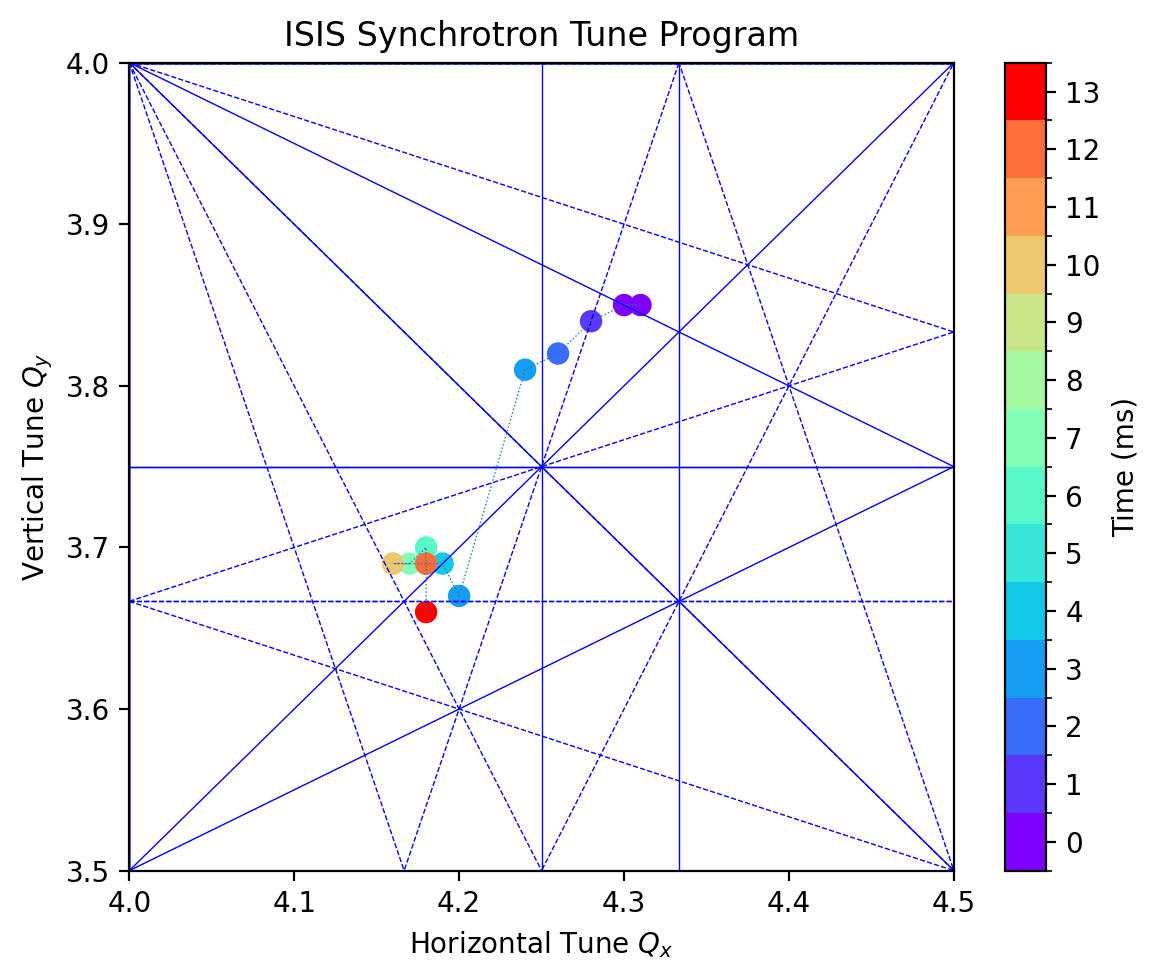

In [17]:
resonance_graph_plotter(np.array(q_df['Qh']), np.array(q_df['Qv']), np.array(q_df['cycle_time'], dtype=float), xlims=(4.0, 4.5), ylims=(3.5, 4.0))

# Run parallel cpymad sims: Orbit

In [18]:
import random
import concurrent.futures


from cpymad.madx import Madx
from cpymad.madx import Sequence
from cpymad.madx import SequenceMap
from cpymad.types import Constraint
import pandas as pd
import numpy as np
import math
from math import log10, floor
import tfs
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch, Rectangle
from scipy.constants import c, m_p, e

def cpymad_start(cpymad_logfile = './cpymad_logfile.log'):
    f = open(cpymad_logfile, 'w')
    madx_instance = Madx(stdout=f)      
    madx_instance.options.echo=True
    madx_instance.options.warn=True
    
    log_string = '! cpymad_start called'
    cpymad_write_to_logfile(cpymad_logfile, log_string)
    
    return madx_instance

def cpymad_write_to_logfile(cpymad_logfile, log_string):
    f = open(cpymad_logfile, 'a')
    f.write('\n')
    f.write(log_string)
    f.close()


def make_directory(path, overwrite=False):
    if os.path.isdir(path):
        print ("Directory %s exists" % path)  
        
        if overwrite:
            os.rmdir(path)
            print ("Directory %s removed" % path)  
            try:
                os.mkdir(path)
            except OSError:
                print ("Creation of the directory %s failed" % path)
            else:
                print ("Successfully created the directory %s" % path)  
    else:
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s" % path)

class MADX_Proton_Beam_Parameters:                
    mass = 938.272E6 # in eV
    energy = -1. # in eV   
    beta = -1.
    gamma = -1.
    total_energy = -1.
    momentum = -1.

    def __init__(self, energy):
        self.energy = energy
        self.total_energy = self.get_total_energy()
        self.gamma = self.get_gamma()
        self.beta = self.get_beta()
        self.momentum = self.get_momentum()
        self.rigidity = self.get_rigidity()

    def get_total_energy(self): return (self.energy + self.mass)
    def get_gamma(self): return (self.total_energy / self.mass)
    def get_beta(self): return(np.sqrt( 1 - (1/self.gamma)**2 ))
    def get_momentum(self): return(self.gamma * self.mass * self.beta)
    def get_rigidity(self): return (self.momentum/299792458)
    
    def print_beam(self):
        print('M_proton = ', round_sig(self.mass/1E6) , 'MeV')
        print('Energy = ', round_sig(self.energy/1E9) , 'GeV')
        print('Total Energy = ', round_sig(self.total_energy/1.E9), 'GeV')
        print('Gamma = ', round_sig(self.gamma))
        print('Beta = ', round_sig(self.beta))
        print('Momentum = ', round_sig(self.momentum/1E9, 8), 'GeV/c')       
        print('Rigidity = ', round_sig(self.rigidity), 'Tm')

def synchrotron_momentum(max_E, time):
    mpeV = m_p * c**2 / e           # Proton mass in eV
    R0 = 26                         # Mean machine radius
    n_dip = 10                      # Number of dipoles
    dip_l = 4.4                     # Dipole length
    
    dip_angle = 2 * np.pi / n_dip   # Dipole bending angle
    rho = dip_l / dip_angle         # Dipole radius of curvature
    omega = 2 * np.pi * 50   
    
    Ek = np.array([70, max_E]) * 1e6 # Injection and extraction kinetic energies 
    E = Ek + mpeV                    # Injection and extraction kinetic energies
    p = np.sqrt(E**2 - mpeV**2)      # Injection and extraction momenta

    B = p / c / rho                  # Ideal magnetic field at injection and extraction energies
    
    Bdip = lambda t: (B[1] + B[0] - (B[1] - B[0]) * np.cos(omega * t)) / 2  # Idealised B-field variation with AC
    pdip = lambda t: Bdip(t) * rho * c                                      # Momentum from B-field in MeV
    
    return pdip(time*1E-3)

def synchrotron_kinetic_energy(max_E, time):
    mpeV = m_p * c**2 / e           # Proton mass in eV    
    # Relativistic Kinetic Energy = Relativistic Energy - mass
    return (np.sqrt(synchrotron_momentum(max_E, time)**2 + mpeV**2) - mpeV) # Return array in eV
    #return (np.sqrt(synchrotron_momentum(max_E, time)**2 + mpeV**2) - mpeV)/1E6 # Return array in MeV

def synchrotron_kinetic_energy_data(max_E, time):
    
    energy = synchrotron_kinetic_energy(max_E, time)
    beam = MADX_Proton_Beam_Parameters(energy)

    gamma = []
    beta = []
    momentum = []
    rigidity = []
    e_mev = []    
    
    mpeV = m_p * c**2 / e           # Proton mass in eV

    e_mev.append((beam.get_total_energy()-mpeV)/1.E6)
    gamma.append(beam.get_gamma())
    beta.append(beam.get_beta())
    momentum.append(beam.get_momentum()/1E9)
    rigidity.append(beam.get_rigidity())

    df = pd.DataFrame({'Time [ms]':time, 'Energy [eV]':energy, 'Energy [MeV]':e_mev, 'Momentum [GeV/c]': momentum, 'Gamma': gamma, 'Beta': beta, 'Rigidity [Tm]':rigidity})
        
    return df

def round_sig(x, sig=3):
    if x == 0.0 : return 0.0
    else: return round(x, sig-int(floor(log10(abs(x))))-1)  

def calculate_steering_kick(amps, max_E, time, plane ='H', sp=0):
    
    sp_list = [0, 2, 3, 4, 5, 7, 9]
    if sp not in sp_list:
        print('calculate_steering_kick:: selected super-period has no steering magnet')
        exit(0)
    
    # Calibration provided by HVC 30.09.22
    calibration_data = {
        '0H' : 0.08350,
        '2H' : 0.09121,
        '3H' : 0.08,
        '4H' : 0.06600,
        '5H' : 0.07780,
        '7H' : 0.07580,
        '9H' : 0.07660,
        '0V' : 0.04620,
        '2V' : 0.04330,
        '3V' : 0.05210,
        '4V' : 0.04770,
        '5V' : 0.05400,
        '7V' : 0.05220,
        '9V' : 0.04510,    
    }
    
    df = synchrotron_kinetic_energy_data(max_E, time)
        
    h_list = ['h', 'H', 'horizontal', 'Horizontal']
    if plane in h_list: key = str(sp) + 'H'   
    else: key = str(sp) + 'V'        
        
    return round_sig(float(amps*(calibration_data[key]/df['Rigidity [Tm]'])))

def cpymad_get_active_sequence(madx_instance): return SequenceMap(madx_instance)

def cpymad_check_and_use_sequence(madx_instance, cpymad_logfile, sequence_name):     
        if sequence_name in cpymad_get_active_sequence(madx_instance):
            madx_instance.use(sequence=sequence_name)
            print('Sequence ', str(sequence_name), ' is active.')
            return True
        else:         
            madx_instance.use(sequence=sequence_name)
            if 'warning' and sequence_name in cpymad_get_output(cpymad_logfile)[0][-1]:
                print(cpymad_get_output(cpymad_logfile)[0][-1])
                print('cpymad_check_and_use_sequence::Sequence not valid in this instance of MAD-X')           
                log_string = '! cpymad_check_and_use_sequence called for sequence ' + sequence_name
                cpymad_write_to_logfile(cpymad_logfile, log_string)  
                return False
            else: 
                print('Sequence',sequence_name,'exists in this instance of MAD-X. Active sequences:')
                print(cpymad_get_active_sequence(madx_instance))       
                log_string = '! cpymad_check_and_use_sequence called for sequence ' + sequence_name
                cpymad_write_to_logfile(cpymad_logfile, log_string)  
                return True

def cpymad_madx_twiss(madx_instance, cpymad_logfile, sequence_name, file_out=None):  
    if cpymad_check_and_use_sequence(madx_instance, cpymad_logfile, sequence_name):
        
        log_string = '! cpymad_madx_twiss called for sequence ' + sequence_name
        cpymad_write_to_logfile(cpymad_logfile, log_string)
        
        if file_out is None: file_out = sequence_name +'_madx_twiss.tfs'
    
        madx_instance.input('set, format="12.12f"')
        madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
        madx_instance.twiss(sequence=sequence_name, file=file_out)
        
        return madx_instance.table.twiss.dframe()

In [40]:
import concurrent.futures
import random
from datetime import datetime

def run_cpymad_simulation(amps, n, timeperiod=800, save_folder='cpymad_save', cpymad_logfile='cpymad_logfile.txt', lattice_folder='../Lattice_Files/01_Original_Lattice/'):
    make_directory(save_folder)
    madx = cpymad_start(cpymad_logfile)

    madx.call(file=lattice_folder+'ISIS.injected_beam')
    madx.call(file=lattice_folder+'ISIS.strength')
    madx.call(file=lattice_folder+'bare_tune_scaling.strength')
    madx.call(file=lattice_folder+'ISIS.elements')
    madx.call(file=lattice_folder+'ISIS.sequence')

    sequence_name = 'synchrotron'

    # Change correctors function
    madx.globals.r0hd1_kick = calculate_steering_kick(amps[0], 800, timeperiod, plane='H', sp=0)
    madx.globals.r2hd1_kick = calculate_steering_kick(amps[1], 800, timeperiod, plane='H', sp=2)
    madx.globals.r3hd1_kick = calculate_steering_kick(amps[2], 800, timeperiod, plane='H', sp=3)
    madx.globals.r4hd1_kick = calculate_steering_kick(amps[3], 800, timeperiod, plane='H', sp=4)
    madx.globals.r5hd1_kick = calculate_steering_kick(amps[4], 800, timeperiod, plane='H', sp=5)
    madx.globals.r7hd1_kick = calculate_steering_kick(amps[5], 800, timeperiod, plane='H', sp=7)
    madx.globals.r9hd1_kick = calculate_steering_kick(amps[6], 800, timeperiod, plane='H', sp=9)
    madx.globals.r0vd1_kick = calculate_steering_kick(amps[7], 800, timeperiod, plane='V', sp=0)
    madx.globals.r2vd1_kick = calculate_steering_kick(amps[8], 800, timeperiod, plane='V', sp=2)
    madx.globals.r3vd1_kick = calculate_steering_kick(amps[9], 800, timeperiod, plane='V', sp=3)
    madx.globals.r4vd1_kick = calculate_steering_kick(amps[10], 800, timeperiod, plane='V', sp=4)
    madx.globals.r5vd1_kick = calculate_steering_kick(amps[11], 800, timeperiod, plane='V', sp=5)
    madx.globals.r7vd1_kick = calculate_steering_kick(amps[12], 800, timeperiod, plane='V', sp=7)
    madx.globals.r9vd1_kick = calculate_steering_kick(amps[13], 800, timeperiod, plane='V', sp=9)

    tfs_save_file = save_folder + '/ISIS_Twiss_'+str(n)+'.tfs'
    twiss_df.append(cpymad_madx_twiss(madx, cpymad_logfile, sequence_name, file_out=tfs_save_file))
    madx.quit()
    
    return twiss_df

def run_parallel_simulations(N, array): # N length array of (#correctors) arrays):

    if len(array) != N: # check that length of array = N
        return "Error"

    for i in range(0, N): # check that length of arrays within array are all equal, and equal to expected number --> e.g. 14 for V and H
        if len(array[i]) != 14:
            return "Error"

    with concurrent.futures.ThreadPoolExecutor(max_workers=N) as executor:
        futures = [executor.submit(run_cpymad_simulation, param, array.index(param)) for param in array]
    
    #return futures

In [41]:
# Dummy data inputs
upper = 0.003
lower = -0.003
global twiss_df

N = 10
input_array = []
twiss_df = []

for i in range(N):
    amps = [random.uniform(lower, upper) for _ in range(14)]
    input_array.append(amps)

In [42]:
run_parallel_simulations(N, input_array)

Directory cpymad_save exists
Directory cpymad_save exists
Directory cpymad_save exists
Directory cpymad_save exists
Directory cpymad_save exists
Directory cpymad_save exists
Directory cpymad_save exists
Directory cpymad_save exists
Directory cpymad_save exists
Directory cpymad_save exists
Sequence  synchrotron  is active.
Sequence  synchrotron  is active.
Sequence  synchrotron  is active.
Sequence  synchrotron  is active.
Sequence  synchrotron  is active.
Sequence  synchrotron  is active.
Sequence  synchrotron  is active.
Sequence  synchrotron  is active.
Sequence  synchrotron  is active.
Sequence  synchrotron  is active.


In [43]:
ls cpymad_save/

final_plot.png    ISIS_Twiss_2.tfs  ISIS_Twiss_5.tfs  ISIS_Twiss_8.tfs
ISIS_Twiss_0.tfs  ISIS_Twiss_3.tfs  ISIS_Twiss_6.tfs  ISIS_Twiss_9.tfs
ISIS_Twiss_1.tfs  ISIS_Twiss_4.tfs  ISIS_Twiss_7.tfs


In [44]:
save_folder = 'cpymad_save'
tdf0 = tfs.read_tfs(save_folder + '/ISIS_Twiss_0.tfs')
tdf1 = tfs.read_tfs(save_folder + '/ISIS_Twiss_1.tfs')
tdf2 = tfs.read_tfs(save_folder + '/ISIS_Twiss_2.tfs')
tdf3 = tfs.read_tfs(save_folder + '/ISIS_Twiss_3.tfs')
tdf4 = tfs.read_tfs(save_folder + '/ISIS_Twiss_4.tfs')
tdf5 = tfs.read_tfs(save_folder + '/ISIS_Twiss_5.tfs')
tdf6 = tfs.read_tfs(save_folder + '/ISIS_Twiss_6.tfs')
tdf7 = tfs.read_tfs(save_folder + '/ISIS_Twiss_7.tfs')
tdf8 = tfs.read_tfs(save_folder + '/ISIS_Twiss_8.tfs')
tdf9 = tfs.read_tfs(save_folder + '/ISIS_Twiss_9.tfs')

In [45]:
df_array = [tdf0, tdf1, tdf2, tdf3, tdf4, tdf5, tdf6, tdf7, tdf8, tdf9]

In [52]:
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm
import numpy as np
from matplotlib.colors import Normalize

def cpymad_plot_COH(twsarray, save_file, plot_indices=None, xlimits=None, ylimits=None, ptc_twiss=False):
    # Ensure DataFrame columns are in lower case
    for df in twsarray:
        df.columns = [x.lower() for x in df.columns]
    
    # If PTC twiss data, process header for additional information
    if ptc_twiss:
        gamma_key = 'gamma'
        pc_key = 'pc'
        ptc_twiss_header = dict(df.headers)
        gamma_rel = ptc_twiss_header[gamma_key]
        beta_rel = np.sqrt(1. - (1. / gamma_rel**2))
        p_mass_GeV = 0.93827208816  # Proton mass in GeV
        tot_energy = gamma_rel * p_mass_GeV
        kin_energy = tot_energy - p_mass_GeV
        momentum = ptc_twiss_header[pc_key]
    
        print('Relativistic Gamma = ', round(gamma_rel, 3))
        print('Relativistic Beta = ', round(beta_rel, 3))
        print('Total Energy = ', round(tot_energy, 4), 'GeV')
        print('Kinetic Energy = ', round(kin_energy * 1E3, 3), 'MeV')
        print('Momentum = ', round(momentum, 3), 'GeV/c')
        
        qx = ptc_twiss_header['q1']
        qy = ptc_twiss_header['q2']
    
    df_array = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 10]

    # Default plot indices to plot all if not specified
    if plot_indices is None:
        plot_indices = df_array
    
    # Start Plotting
    heights = [4, 4]
    fig = plt.figure(figsize=(10, 8), facecolor='w', edgecolor='k', constrained_layout=True)
    spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=heights)
    
    max_colors = 19
    colormap = cm.get_cmap('jet', max_colors)
    norm = Normalize(vmin=0, vmax=10)  # Adjusted normalization based on max value in df_array
    
    f2_ax3 = fig.add_subplot(spec[0])
    for i in plot_indices:
        if i in df_array:
            idx = df_array.index(i)
            df = twsarray[i]
            color = colormap(idx)
            f2_ax3.plot(df['s'], df['x']*1E3, color=color, lw=1.5) #, label=f'Horizontal Closed Orbit @ {idx:.1f}ms')
    f2_ax3.set_ylabel('x [mm]')
    f2_ax3.grid(which='both', ls=':', lw=0.5, color='k')

    if xlimits is not None:
        f2_ax3.set_xlim(xlimits)

    if ylimits is not None:
        f2_ax3.set_ylim(ylimits)
    
    # Add the colorbar
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])  # Only needed for matplotlib < 3.1
    cbar = fig.colorbar(sm, ax=[f2_ax3], aspect=50, pad=0.02, ticks=np.arange(0, 10.5, 0.5))
    cbar.set_label('Time (ms)')
    
    plt.title('ISIS Synchrotron Horizontal Orbits')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

/tmp/ipykernel_89686/999471292.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet', max_colors)


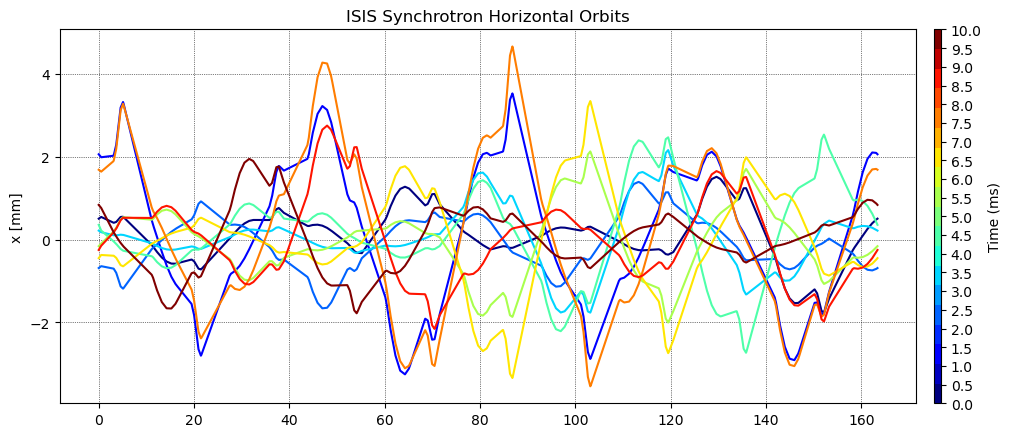

In [53]:
plot_save_file = save_folder + '/final_plot.png'
cpymad_plot_COH(df_array, plot_save_file, plot_indices=[0,1,2,3,4,5,6,7,8,9])#, ylimits=(-10,10))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm
import numpy as np
from matplotlib.colors import Normalize

def cpymad_plot_COH_EPICS(twsarray, save_file, df_idxarray = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 10], plot_indices=None, xlimits=None, ylimits=None, ptc_twiss=False):
    # Ensure DataFrame columns are in lower case
    for df in twsarray:
        df.columns = [x.lower() for x in df.columns]
    
    # If PTC twiss data, process header for additional information
    if ptc_twiss:
        gamma_key = 'gamma'
        pc_key = 'pc'
        ptc_twiss_header = dict(df.headers)
        gamma_rel = ptc_twiss_header[gamma_key]
        beta_rel = np.sqrt(1. - (1. / gamma_rel**2))
        p_mass_GeV = 0.93827208816  # Proton mass in GeV
        tot_energy = gamma_rel * p_mass_GeV
        kin_energy = tot_energy - p_mass_GeV
        momentum = ptc_twiss_header[pc_key]
    
        print('Relativistic Gamma = ', round(gamma_rel, 3))
        print('Relativistic Beta = ', round(beta_rel, 3))
        print('Total Energy = ', round(tot_energy, 4), 'GeV')
        print('Kinetic Energy = ', round(kin_energy * 1E3, 3), 'MeV')
        print('Momentum = ', round(momentum, 3), 'GeV/c')
        
        qx = ptc_twiss_header['q1']
        qy = ptc_twiss_header['q2']


    # Default plot indices to plot all if not specified
    if plot_indices is None:
        plot_indices = df_idxarray
    
    # Start Plotting
    heights = [4, 4]
    fig = plt.figure(figsize=(10, 8), facecolor='w', edgecolor='k', constrained_layout=True)
    spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=heights)
    
    max_colors = 19
    colormap = cm.get_cmap('jet', max_colors)
    norm = Normalize(vmin=0, vmax=10)  # Adjusted normalization based on max value in df_array

    index_to_colour = {i: colormap(norm(i)) for i in range(max_colors)}
    
    f2_ax3 = fig.add_subplot(spec[0])
    for i in plot_indices:
        if i in df_idxarray:
            idx = df_idxarray.index(i)
            df = twsarray[idx]
            color = index_to_colour[i]
            f2_ax3.plot(df['s'], df['y']*1E3, color=color, lw=1.5) #, label=f'Horizontal Closed Orbit @ {idx:.1f}ms')
    f2_ax3.set_ylabel('y [mm]')
    f2_ax3.grid(which='both', ls=':', lw=0.5, color='k')

    if xlimits is not None:
        f2_ax3.set_xlim(xlimits)

    if ylimits is not None:
        f2_ax3.set_ylim(ylimits)
    
    # Add the colorbar
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])  # Only needed for matplotlib < 3.1
    cbar = fig.colorbar(sm, ax=[f2_ax3], aspect=50, pad=0.02, ticks=np.arange(0, 10.5, 0.5))
    cbar.set_label('Time (ms)')
    
    plt.title('ISIS Synchrotron Horizontal Orbits')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

## Plot closed orbits from archive settings

In [101]:
def cpymad_plot_COHV_Archive(twsarray, save_file, df_idxarray = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 9], plot_indices=None, xlimits = None, ylimits = None, ptc_twiss=False):
    # Ensure DataFrame columns are in lower case
    for df in twsarray:
        df.columns = [x.lower() for x in df.columns]
    
    # If PTC twiss data, process header for additional information
    if ptc_twiss:
        gamma_key = 'gamma'
        pc_key = 'pc'
        ptc_twiss_header = dict(df.headers)
        gamma_rel = ptc_twiss_header[gamma_key]
        beta_rel = np.sqrt(1. - (1. / gamma_rel**2))
        p_mass_GeV = 0.93827208816  # Proton mass in GeV
        tot_energy = gamma_rel * p_mass_GeV
        kin_energy = tot_energy - p_mass_GeV
        momentum = ptc_twiss_header[pc_key]
    
        print('Relativistic Gamma = ', round(gamma_rel, 3))
        print('Relativistic Beta = ', round(beta_rel, 3))
        print('Total Energy = ', round(tot_energy, 4), 'GeV')
        print('Kinetic Energy = ', round(kin_energy * 1E3, 3), 'MeV')
        print('Momentum = ', round(momentum, 3), 'GeV/c')
        
        qx = ptc_twiss_header['q1']
        qy = ptc_twiss_header['q2']
    df_array = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 9]
    
    # Default plot indices to plot all if not specified
    if plot_indices == []:
        plot_indices = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 9]
    
    # Start Plotting
    heights = [4, 4]
    fig = plt.figure(figsize=(10, 8), facecolor='w', edgecolor='k', constrained_layout=True)
    spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=heights)
    
    max_colors = 19
    colormap = cm.get_cmap('jet', max_colors)
    norm = Normalize(vmin=0, vmax=9.5)  # Adjusted normalization based on max value in plot_indices

    index_to_colour = {i: colormap(norm(i)) for i in range(max_colors)}
    
    f2_ax3 = fig.add_subplot(spec[0])
    for i in plot_indices:
        if i in df_idxarray:
            idx = df_idxarray.index(i)
            df = twsarray[idx]
            color = index_to_colour[i]
            f2_ax3.plot(df['s'], df['x']*1E3, color=color, lw=1.5) #, label=f'Horizontal Closed Orbit @ {idx:.1f}ms')
    f2_ax3.set_ylabel('x [mm]')
    f2_ax3.grid(which='both', ls=':', lw=0.5, color='k')
    
    f2_ax4 = fig.add_subplot(spec[1], sharex=f2_ax3)
    for i in plot_indices:
        if i in df_idxarray:
            idx = df_idxarray.index(i)
            df = twsarray[idx]
            color = index_to_colour[i]
            f2_ax4.plot(df['s'], df['y']*1E3, color=color, lw=1.5) #, label=f'Horizontal Closed Orbit @ {idx:.1f}ms')
    f2_ax4.set_ylabel('y [mm]')
    f2_ax4.grid(which='both', ls=':', lw=0.5, color='k')
    f2_ax4.set_xlabel('s [m]')

    if xlimits != None:
        f2_ax3.set_xlim(xlimits)
        f2_ax4.set_xlim(xlimits)

    if ylimits != None:
        f2_ax3.set_ylim(ylimits)
        f2_ax4.set_ylim(ylimits)
    # Add the colorbar
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])  # Only needed for matplotlib < 3.1
    cbar = fig.colorbar(sm, ax=[f2_ax3, f2_ax4], aspect=50, pad=0.02, ticks=np.arange(0, 9.5, 0.5))
    cbar.set_label('Time (ms)')
    plt.suptitle('ISIS Synchrotron Closed Orbits')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

/tmp/ipykernel_89686/2483154336.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet', max_colors)


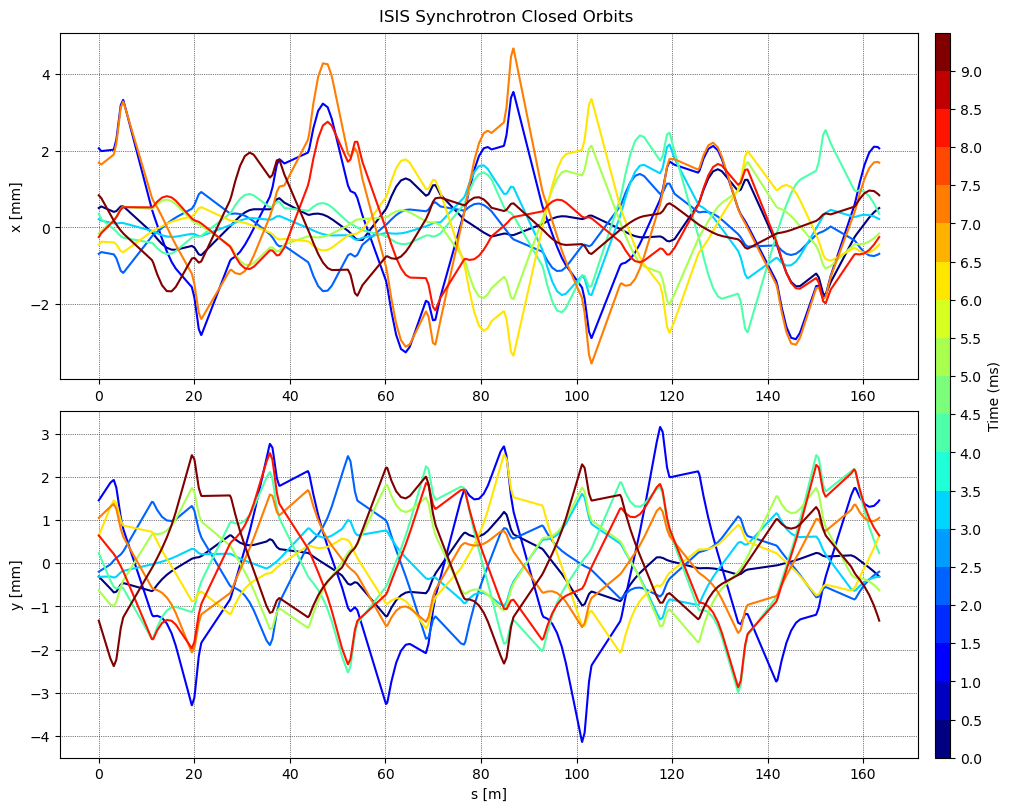

In [102]:
plot_save_file = save_folder + '/final_plot.png'
#cpymad_plot_COH(df_array, plot_save_file, plot_indices=[0,1,2,3,4,5,6,7,8,9])#, ylimits=(-10,10))
cpymad_plot_COHV_Archive(df_array, plot_save_file, df_idxarray = [0, 1, 2, 3, 4, 5, 6,7,8, 9], plot_indices=[0, 1, 2, 3, 4, 5, 6,7,8, 9], xlimits = None, ylimits = None, ptc_twiss=False)
    

In [ ]:
break

In [ ]:
from cpymad.madx import Madx
from cpymad.madx import Sequence
from cpymad.madx import SequenceMap
from cpymad.types import Constraint
import pandas as pd
import numpy as np
import math
from math import log10, floor
import tfs
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch, Rectangle
from scipy.constants import c, m_p, e

---
#### Functions

In [ ]:
def make_directory(path, overwrite=False):
    if os.path.isdir(path):
        print ("Directory %s exists" % path)  
        
        if overwrite:
            os.rmdir(path)
            print ("Directory %s removed" % path)  
            try:
                os.mkdir(path)
            except OSError:
                print ("Creation of the directory %s failed" % path)
            else:
                print ("Successfully created the directory %s" % path)  
    else:
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s" % path)  

In [ ]:
def cpymad_start(cpymad_logfile = './cpymad_logfile.log'):
    f = open(cpymad_logfile, 'w')
    madx_instance = Madx(stdout=f)      
    madx_instance.options.echo=True
    madx_instance.options.warn=True
    
    log_string = '! cpymad_start called'
    cpymad_write_to_logfile(cpymad_logfile, log_string)
    
    return madx_instance

In [ ]:
def cpymad_write_to_logfile(cpymad_logfile, log_string):
    f = open(cpymad_logfile, 'a')
    f.write('\n')
    f.write(log_string)
    f.close()

In [ ]:
def cpymad_get_active_sequence(madx_instance): return SequenceMap(madx_instance)

In [ ]:
def cpymad_check_and_use_sequence(madx_instance, cpymad_logfile, sequence_name):     
        if sequence_name in cpymad_get_active_sequence(madx_instance):
            madx_instance.use(sequence=sequence_name)
            print('Sequence ', str(sequence_name), ' is active.')
            return True
        else:         
            madx_instance.use(sequence=sequence_name)
            if 'warning' and sequence_name in cpymad_get_output(cpymad_logfile)[0][-1]:
                print(cpymad_get_output(cpymad_logfile)[0][-1])
                print('cpymad_check_and_use_sequence::Sequence not valid in this instance of MAD-X')           
                log_string = '! cpymad_check_and_use_sequence called for sequence ' + sequence_name
                cpymad_write_to_logfile(cpymad_logfile, log_string)  
                return False
            else: 
                print('Sequence',sequence_name,'exists in this instance of MAD-X. Active sequences:')
                print(cpymad_get_active_sequence(madx_instance))       
                log_string = '! cpymad_check_and_use_sequence called for sequence ' + sequence_name
                cpymad_write_to_logfile(cpymad_logfile, log_string)  
                return True

In [ ]:
def isis_reset_trim_quads(madx_instance):   
    
    # trim quads
    madx_instance.globals.kqtd_0 = 'kqtd + HER0qtd'
    madx_instance.globals.kqtd_1 = 'kqtd + HER1qtd'
    madx_instance.globals.kqtd_2 = 'kqtd + HER2qtd'
    madx_instance.globals.kqtd_3 = 'kqtd + HER3qtd'
    madx_instance.globals.kqtd_4 = 'kqtd + HER4qtd'
    madx_instance.globals.kqtd_5 = 'kqtd + HER5qtd'
    madx_instance.globals.kqtd_6 = 'kqtd + HER6qtd'     
    madx_instance.globals.kqtd_7 = 'kqtd + HER7qtd'
    madx_instance.globals.kqtd_8 = 'kqtd + HER8qtd'
    madx_instance.globals.kqtd_9 = 'kqtd + HER9qtd'
    
    madx_instance.globals.kqtf_0 = 'kqtf + HER0qtf'
    madx_instance.globals.kqtf_1 = 'kqtf + HER1qtf'
    madx_instance.globals.kqtf_2 = 'kqtf + HER2qtf'
    madx_instance.globals.kqtf_3 = 'kqtf + HER3qtf'
    madx_instance.globals.kqtf_4 = 'kqtf + HER4qtf'
    madx_instance.globals.kqtf_5 = 'kqtf + HER5qtf'
    madx_instance.globals.kqtf_6 = 'kqtf + HER6qtf'     
    madx_instance.globals.kqtf_7 = 'kqtf + HER7qtf'
    madx_instance.globals.kqtf_8 = 'kqtf + HER8qtf'
    madx_instance.globals.kqtf_9 = 'kqtf + HER9qtf'

In [ ]:
def isis_print_trim_quads(madx_instance):   
    
    # Steering magnets
    print(madx_instance.globals.kqtd_0,
    madx_instance.globals.kqtd_1,
    madx_instance.globals.kqtd_2,
    madx_instance.globals.kqtd_3,
    madx_instance.globals.kqtd_4,
    madx_instance.globals.kqtd_5,
    madx_instance.globals.kqtd_6,      
    madx_instance.globals.kqtd_7,
    madx_instance.globals.kqtd_8,
    madx_instance.globals.kqtd_9,    
    madx_instance.globals.kqtf_0,
    madx_instance.globals.kqtf_1,
    madx_instance.globals.kqtf_2,
    madx_instance.globals.kqtf_3,
    madx_instance.globals.kqtf_4,
    madx_instance.globals.kqtf_5,
    madx_instance.globals.kqtf_6,      
    madx_instance.globals.kqtf_7,
    madx_instance.globals.kqtf_8,
    madx_instance.globals.kqtf_9)

In [ ]:
def isis_reset_steering_correctors(madx_instance):   
    
    # Steering magnets
    madx_instance.globals.r0hd1_kick = 0.0
    madx_instance.globals.r2hd1_kick = 0.0
    madx_instance.globals.r3hd1_kick = 0.0
    madx_instance.globals.r4hd1_kick = 0.0
    madx_instance.globals.r5hd1_kick = 0.0
    madx_instance.globals.r7hd1_kick = 0.0
    madx_instance.globals.r9hd1_kick = 0.0      
    madx_instance.globals.r0vd1_kick = 0.0
    madx_instance.globals.r2vd1_kick = 0.0
    madx_instance.globals.r3vd1_kick = 0.0
    madx_instance.globals.r4vd1_kick = 0.0
    madx_instance.globals.r5vd1_kick = 0.0
    madx_instance.globals.r7vd1_kick = 0.0
    madx_instance.globals.r9vd1_kick = 0.0 

In [ ]:
def isis_print_steering_correctors(madx_instance):   
    
    # Steering magnets
    print(madx_instance.globals.r0hd1_kick,
    madx_instance.globals.r2hd1_kick,
    madx_instance.globals.r3hd1_kick,
    madx_instance.globals.r4hd1_kick,
    madx_instance.globals.r5hd1_kick,
    madx_instance.globals.r7hd1_kick,
    madx_instance.globals.r9hd1_kick,      
    madx_instance.globals.r0vd1_kick,
    madx_instance.globals.r2vd1_kick,
    madx_instance.globals.r3vd1_kick,
    madx_instance.globals.r4vd1_kick,
    madx_instance.globals.r5vd1_kick,
    madx_instance.globals.r7vd1_kick,
    madx_instance.globals.r9vd1_kick)

In [ ]:
def cpymad_madx_twiss(madx_instance, cpymad_logfile, sequence_name, file_out=None):  
    if cpymad_check_and_use_sequence(madx_instance, cpymad_logfile, sequence_name):
        
        log_string = '! cpymad_madx_twiss called for sequence ' + sequence_name
        cpymad_write_to_logfile(cpymad_logfile, log_string)
        
        if file_out is None: file_out = sequence_name +'_madx_twiss.tfs'
    
        madx_instance.input('set, format="12.12f"')
        madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
        madx_instance.twiss(sequence=sequence_name, file=file_out)
        
        return madx_instance.table.twiss.dframe()

In [ ]:
def cpymad_madx_twiss_nocheck(madx_instance, cpymad_logfile, sequence_name, file_out=None):  
    log_string = '! cpymad_madx_twiss_nocheck called for sequence ' + sequence_name
    cpymad_write_to_logfile(cpymad_logfile, log_string)

    if file_out is None: file_out = sequence_name +'_madx_twiss.tfs'

    madx_instance.input('set, format="12.12f"')
    madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
    madx_instance.twiss(sequence=sequence_name, file=file_out)

    return madx_instance.table.twiss.dframe()

In [ ]:
def round_up_n(x,n):
    return int(math.ceil(x / n)) * int(n)

In [ ]:
def round_down_n(x,n):
    return int(math.floor(x / n)) * int(n)

In [ ]:
def block_diagram(ax1, df_myTwiss, limits=None, ptc_twiss=False):
    
    # Remove Borders
    ax1.spines['top'].set_visible(False);
    ax1.spines['bottom'].set_visible(False);
    ax1.spines['left'].set_visible(False);
    ax1.spines['right'].set_visible(False);
    ax1.axes.get_yaxis().set_visible(False); 
    ax1.axes.get_xaxis().set_visible(False);  
    
    s_key =  's'
    keyword = 'keyword'  
    
    ############
    ## Marker ##
    ############
    if ptc_twiss: key = 'MARKER'
    else: key =  'marker'
    DF=df_myTwiss[(df_myTwiss[keyword]==key)]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        ax1.add_patch(patches.Rectangle( (DF.iloc[i].s-0.1, 0.), 0.1, 1.0, color='k', alpha=0.5))
                    
    custom_lines = [Line2D([0], [0], color='b', lw=4, alpha=0.5),
                    Line2D([0], [0], color='r', lw=4, alpha=0.5),
                    Line2D([0], [0], color='green', lw=4, alpha=0.5),
                    Line2D([0], [0], color='cyan', lw=4, alpha=0.5),
                    Line2D([0], [0], color='k', lw=4, alpha=0.5)]
    ############
    ## Kicker ##
    ############     
    kicker_length=0.5
    kicker_height = 1.0
    if ptc_twiss: key = 'KICKER'
    else: key =  'kicker'
    DF=df_myTwiss[(df_myTwiss[keyword]==key)]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        ax1.add_patch(patches.Rectangle( (DF.iloc[i].s, 0.), kicker_length, kicker_height, color='c', alpha=0.5));

    if ptc_twiss: key = 'HKICKER'
    else: key =  'hkicker'
    DF=df_myTwiss[(df_myTwiss[keyword]==key)]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        ax1.add_patch(patches.Rectangle( (DF.iloc[i].s, 0.), kicker_length, kicker_height, color='c', alpha=0.5));

    if ptc_twiss: key = 'VKICKER'
    else: key =  'vkicker'
    DF=df_myTwiss[(df_myTwiss[keyword]==key)]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        ax1.add_patch(patches.Rectangle( (DF.iloc[i].s, 0.), kicker_length, kicker_height, color='c', alpha=0.5));
    
    ###############
    ## Sextupole ##
    ###############
    if ptc_twiss: key = 'SEXTUPOLE'
    else: key =  'sextupole'
    DF=df_myTwiss[(df_myTwiss[keyword]==key)]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        ax1.add_patch(patches.Rectangle( (DF.iloc[i].s-DF.iloc[i].l, 0.), DF.iloc[i].l, 1.0, color='green', alpha=0.5));
        
    ###########
    ## QUADS ##
    ########### 
    if ptc_twiss: key = 'QUADRUPOLE'
    else: key =  'quadrupole'
    DF=df_myTwiss[(df_myTwiss[keyword]==key)]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        ax1.add_patch(patches.Rectangle( (DF.iloc[i].s-DF.iloc[i].l, 0.), DF.iloc[i].l, 1.0, color='r', alpha=0.5));
    
    ###########
    ## BENDS ##
    ########### 
    if ptc_twiss: key = 'SBEND'
    else: key =  'sbend'
    DF=df_myTwiss[(df_myTwiss[keyword]==key)]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        ax1.add_patch(patches.Rectangle( (DF.iloc[i].s-DF.iloc[i].l, 0.), DF.iloc[i].l, 1.0, color='b', alpha=0.5));
    
    if ptc_twiss: key = 'RBEND'
    else: key =  'rbend'
    DF=df_myTwiss[(df_myTwiss[keyword]==key)]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        ax1.add_patch(patches.Rectangle( (DF.iloc[i].s-DF.iloc[i].l, 0.), DF.iloc[i].l, 1.0, color='b', alpha=0.5));
                                         
    if limits is not None:
        ax1.set_xlim(limits[0], limits[1]);
    else:
        if ptc_twiss:        
            ax1.set_xlim(0, df_myTwiss.headers['LENGTH']);
        else:
            ax1.set_xlim(0, df_myTwiss.iloc[-1].s); 
    ax1.legend(custom_lines, ['Dipole', 'Quadrupole', 'Sextupole', 'Kicker', 'Marker'], loc=1)


In [ ]:
def cpymad_plot_CO(madx_instance, df_myTwiss, sequence_name, save_file, xlimits = None, ylimits = None, ptc_twiss=False):
        
    if ptc_twiss:
        gamma_key = 'GAMMA'; pc_key='PC';
        ptc_twiss_read_Header = dict(df_myTwiss.headers)
        gamma_rel = ptc_twiss_read_Header[gamma_key]
        beta_rel = np.sqrt( 1. - (1./gamma_rel**2) )
        p_mass_GeV = 0.93827208816 #Proton mass GeV
        tot_energy = gamma_rel * p_mass_GeV
        kin_energy = tot_energy - p_mass_GeV
        momentum = ptc_twiss_read_Header[pc_key]

        print('Relativistic Gamma = ', round(gamma_rel,3))
        print('Relativistic Beta = ', round(beta_rel,3))
        print('Total Energy = ', round(tot_energy,4), 'GeV')
        print('Kinetic Energy = ', round(kin_energy*1E3,3), 'MeV')
        print('momentum = ', round(momentum,3), 'GeV/c')
        
        qx = ptc_twiss_read_Header['Q1']
        qy = ptc_twiss_read_Header['Q2']
    
    else:
        # Plot title = sequence_name + tunes
        qx = madx_instance.table.summ.q1[0]
        qy = madx_instance.table.summ.q2[0]     
    
    plot_title = sequence_name +r' Q$_x$='+format(qx,'2.3f')+r', Q$_y$='+ format(qy,'2.3f')
        
    # Start Plot
    heights = [1, 3, 2, 2]
    fig2 = plt.figure(figsize=(10,8),facecolor='w', edgecolor='k',constrained_layout=True)
    spec2 = gridspec.GridSpec(ncols=1, nrows=4, figure=fig2, height_ratios=heights)
    
    # Block diagram
    f2_ax1 = fig2.add_subplot(spec2[0])
    f2_ax1.set_title(plot_title)  
        
    if xlimits is not None:
        if len(xlimits) != 2:
            print('cpymad_plot_CO::ERROR, xlimits must be given as a 2 variable list such as [0., 1.]')
            raise ValueError()
        if ptc_twiss:
            block_diagram(f2_ax1, df_myTwiss, xlimits, ptc_twiss=True)
        else: 
            block_diagram(f2_ax1, df_myTwiss, xlimits, ptc_twiss=False)
    else:
        if ptc_twiss:
            block_diagram(f2_ax1, df_myTwiss, ptc_twiss=True)
        else: 
            block_diagram(f2_ax1, df_myTwiss, ptc_twiss=False)
    
    # Plot betas   
    f2_ax2 = fig2.add_subplot(spec2[1], sharex=f2_ax1)  
    f2_ax2.plot(df_myTwiss['s'], df_myTwiss['betx'],'b', label='$\\beta_x$')
    f2_ax2.plot(df_myTwiss['s'], df_myTwiss['bety'],'r', label='$\\beta_y$')    
    
    f2_ax2.legend(loc=2)
    f2_ax2.set_ylabel(r'$\beta_{x,y}$[m]')
    f2_ax2.grid(which='both', ls=':', lw=0.5, color='k')
    #f2_ax2.set_xlabel('s [m]')
    #f2_ax2.set_xticklabels([])
    
    if np.min(df_myTwiss['bety']) < np.min(df_myTwiss['betx']): bet_min = round_down_n(np.min(df_myTwiss['bety']),5)
    else: bet_min = round_down_n(np.min(df_myTwiss['betx']),5)
    if np.max(df_myTwiss['bety']) > np.max(df_myTwiss['betx']): bet_max = round_up_n(np.max(df_myTwiss['bety']),10)
    else: bet_max = round_up_n(np.max(df_myTwiss['betx']),10)        
    f2_ax2.set_ylim(bet_min,bet_max)
    
    ax2 = f2_ax2.twinx()   # instantiate a second axes that shares the same x-axis
    if ptc_twiss:     
        ax2.plot(df_myTwiss['s'], df_myTwiss['disp1']/beta_rel,'green', label='$D_x$')
        ax2.plot(df_myTwiss['s'], df_myTwiss['disp3']/beta_rel,'purple', label='$D_y$')
        key_dx = 'disp1';        key_dy = 'disp3';  
    
    else:
        ax2.plot(df_myTwiss['s'], df_myTwiss['dx'],'green', label='$D_x$')
        ax2.plot(df_myTwiss['s'], df_myTwiss['dy'],'purple', label='$D_y$')
        key_dx = 'dx';        key_dy = 'dy';  
        
    ax2.legend(loc=1)
    ax2.set_ylabel(r'$D_{x,y}$ [m]', color='green')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.grid(which='both', ls=':', lw=0.5, color='green')

    if np.min(df_myTwiss[key_dy]) < np.min(df_myTwiss[key_dx]): d_min = round_down_n(np.min(df_myTwiss[key_dy]),1)
    else: d_min = round_down_n(np.min(df_myTwiss[key_dx]),1)    
    if np.max(df_myTwiss[key_dy]) > np.max(df_myTwiss[key_dx]): d_max = round_up_n(np.max(df_myTwiss[key_dy]),10)
    else: d_max = round_up_n(np.max(df_myTwiss[key_dx]),10) 
    ax2.set_ylim(d_min,d_max)   
    
    f2_ax3 = fig2.add_subplot(spec2[2], sharex=f2_ax1)
    f2_ax3.plot(df_myTwiss['s'], df_myTwiss['x']*1E3,'k', lw=1.5, label='Horizontal Closed Orbit')      
    f2_ax3.legend(loc=2)
    f2_ax3.set_ylabel('x [mm]')
    f2_ax3.grid(which='both', ls=':', lw=0.5, color='k')
    
    f2_ax4 = fig2.add_subplot(spec2[3], sharex=f2_ax1)
    f2_ax4.plot(df_myTwiss['s'], df_myTwiss['y']*1E3,'k', lw=1.5, label='Vertical Closed Orbit')    
    f2_ax4.legend(loc=2)
    f2_ax4.set_ylabel('y [mm]')
    f2_ax4.grid(which='both', ls=':', lw=0.5, color='k')
    
    co_min, co_max = -10,10
    if ylimits is not None:
        if len(ylimits) != 2:
            print('cpymad_plot_CO::ERROR, ylimits must be given as a 2 variable list such as [0., 1.]')
            raise ValueError()
        else:
            co_min, co_max = ylimits
        
    else:
        if np.min(df_myTwiss['y']) < np.min(df_myTwiss['x']): co_min = round_down_n(np.min(df_myTwiss['y']*1E3),10)
        else: co_min = round_down_n(np.min(df_myTwiss['x']*1E3),10)
        if np.max(df_myTwiss['y']) > np.max(df_myTwiss['x']): co_max = round_up_n(np.max(df_myTwiss['y']*1E3),10)
        else: co_max = round_up_n(np.max(df_myTwiss['x']*1E3),10)
        
    f2_ax4.set_ylim(co_min,co_max)
    f2_ax3.set_ylim(co_min,co_max)
    
    f2_ax4.set_xlabel('s [m]')
    
    #f2_ax4 = fig2.add_subplot(spec2[4], sharex=f2_ax1)   
    if save_file != None: plt.savefig(save_file)

In [ ]:
def cpymad_plot_CO_aperture(madx_instance, df_myTwiss, df_aperture, sequence_name, save_file, xlimits = None, ylimits = None, ptc_twiss=False):
        
    if ptc_twiss:
        gamma_key = 'GAMMA'; pc_key='PC';
        ptc_twiss_read_Header = dict(df_myTwiss.headers)
        gamma_rel = ptc_twiss_read_Header[gamma_key]
        beta_rel = np.sqrt( 1. - (1./gamma_rel**2) )
        p_mass_GeV = 0.93827208816 #Proton mass GeV
        tot_energy = gamma_rel * p_mass_GeV
        kin_energy = tot_energy - p_mass_GeV
        momentum = ptc_twiss_read_Header[pc_key]

        print('Relativistic Gamma = ', round(gamma_rel,3))
        print('Relativistic Beta = ', round(beta_rel,3))
        print('Total Energy = ', round(tot_energy,4), 'GeV')
        print('Kinetic Energy = ', round(kin_energy*1E3,3), 'MeV')
        print('momentum = ', round(momentum,3), 'GeV/c')
        
        qx = ptc_twiss_read_Header['Q1']
        qy = ptc_twiss_read_Header['Q2']
    
    else:
        # Plot title = sequence_name + tunes
        qx = madx_instance.table.summ.q1[0]
        qy = madx_instance.table.summ.q2[0]     
    
    plot_title = sequence_name +r' Q$_x$='+format(qx,'2.3f')+r', Q$_y$='+ format(qy,'2.3f')
        
    # Start Plot
    heights = [1, 3, 2, 2]
    fig2 = plt.figure(figsize=(10,8),facecolor='w', edgecolor='k',constrained_layout=True)
    spec2 = gridspec.GridSpec(ncols=1, nrows=4, figure=fig2, height_ratios=heights)
    
    # Block diagram
    f2_ax1 = fig2.add_subplot(spec2[0])
    f2_ax1.set_title(plot_title)  
        
    if xlimits is not None:
        if len(xlimits) != 2:
            print('cpymad_plot_CO::ERROR, xlimits must be given as a 2 variable list such as [0., 1.]')
            raise ValueError()
        if ptc_twiss:
            block_diagram(f2_ax1, df_myTwiss, xlimits, ptc_twiss=True)
        else: 
            block_diagram(f2_ax1, df_myTwiss, xlimits, ptc_twiss=False)
    else:
        if ptc_twiss:
            block_diagram(f2_ax1, df_myTwiss, ptc_twiss=True)
        else: 
            block_diagram(f2_ax1, df_myTwiss, ptc_twiss=False)
    
    # Plot betas   
    f2_ax2 = fig2.add_subplot(spec2[1], sharex=f2_ax1)  
    f2_ax2.plot(df_myTwiss['s'], df_myTwiss['betx'],'b', label='$\\beta_x$')
    f2_ax2.plot(df_myTwiss['s'], df_myTwiss['bety'],'r', label='$\\beta_y$')    
    
    f2_ax2.legend(loc=2)
    f2_ax2.set_ylabel(r'$\beta_{x,y}$[m]')
    f2_ax2.grid(which='both', ls=':', lw=0.5, color='k')
    #f2_ax2.set_xlabel('s [m]')
    #f2_ax2.set_xticklabels([])
    
    if np.min(df_myTwiss['bety']) < np.min(df_myTwiss['betx']): bet_min = round_down_n(np.min(df_myTwiss['bety']),5)
    else: bet_min = round_down_n(np.min(df_myTwiss['betx']),5)
    if np.max(df_myTwiss['bety']) > np.max(df_myTwiss['betx']): bet_max = round_up_n(np.max(df_myTwiss['bety']),10)
    else: bet_max = round_up_n(np.max(df_myTwiss['betx']),10)        
    f2_ax2.set_ylim(bet_min,bet_max)
    
    ax2 = f2_ax2.twinx()   # instantiate a second axes that shares the same x-axis
    if ptc_twiss:     
        ax2.plot(df_myTwiss['s'], df_myTwiss['disp1']/beta_rel,'green', label='$D_x$')
        ax2.plot(df_myTwiss['s'], df_myTwiss['disp3']/beta_rel,'purple', label='$D_y$')
        key_dx = 'disp1';        key_dy = 'disp3';  
    
    else:
        ax2.plot(df_myTwiss['s'], df_myTwiss['dx'],'green', label='$D_x$')
        ax2.plot(df_myTwiss['s'], df_myTwiss['dy'],'purple', label='$D_y$')
        key_dx = 'dx';        key_dy = 'dy';  
        
    ax2.legend(loc=1)
    ax2.set_ylabel(r'$D_{x,y}$ [m]', color='green')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.grid(which='both', ls=':', lw=0.5, color='green')

    if np.min(df_myTwiss[key_dy]) < np.min(df_myTwiss[key_dx]): d_min = round_down_n(np.min(df_myTwiss[key_dy]),1)
    else: d_min = round_down_n(np.min(df_myTwiss[key_dx]),1)    
    if np.max(df_myTwiss[key_dy]) > np.max(df_myTwiss[key_dx]): d_max = round_up_n(np.max(df_myTwiss[key_dy]),10)
    else: d_max = round_up_n(np.max(df_myTwiss[key_dx]),10) 
    ax2.set_ylim(d_min,d_max)   
    
    f2_ax3 = fig2.add_subplot(spec2[2], sharex=f2_ax1)
    f2_ax3.plot(df_myTwiss['s'], df_myTwiss['x']*1E3,'k', lw=1.5, label='Horizontal Closed Orbit')      
    #Note that this doesn't include dispersion (needs momentum spread)
    f2_ax3.plot(df_aperture.s, df_aperture.aper_1*1E3, 'r', lw=1, label='Aperture')
    f2_ax3.plot(df_aperture.s, -df_aperture.aper_1*1E3, 'r', lw=1)
    f2_ax3.legend(loc=2)
    f2_ax3.set_ylabel('x [mm]')
    f2_ax3.grid(which='both', ls=':', lw=0.5, color='k')
    
    f2_ax4 = fig2.add_subplot(spec2[3], sharex=f2_ax1)
    f2_ax4.plot(df_myTwiss['s'], df_myTwiss['y']*1E3,'k', lw=1.5, label='Vertical Closed Orbit')    
    #Note that this doesn't include dispersion (needs momentum spread)
    f2_ax4.plot(df_aperture.s, df_aperture.aper_2*1E3, 'r', lw=1, label='Aperture')
    f2_ax4.plot(df_aperture.s, -df_aperture.aper_2*1E3, 'r', lw=1)
    f2_ax4.legend(loc=2)
    f2_ax4.set_ylabel('y [mm]')
    f2_ax4.grid(which='both', ls=':', lw=0.5, color='k')
    
    co_min, co_max = -10,10
    if ylimits is not None:
        if len(ylimits) != 2:
            print('cpymad_plot_CO::ERROR, ylimits must be given as a 2 variable list such as [0., 1.]')
            raise ValueError()
        else:
            co_min, co_max = ylimits
        
    else:
        if np.min(df_myTwiss['y']) < np.min(df_myTwiss['x']): co_min = round_down_n(np.min(df_myTwiss['y']*1E3),10)
        else: co_min = round_down_n(np.min(df_myTwiss['x']*1E3),10)
        if np.max(df_myTwiss['y']) > np.max(df_myTwiss['x']): co_max = round_up_n(np.max(df_myTwiss['y']*1E3),10)
        else: co_max = round_up_n(np.max(df_myTwiss['x']*1E3),10)
        
    #f2_ax4.set_ylim(co_min,co_max)
    #f2_ax3.set_ylim(co_min,co_max)
    
    f2_ax4.set_xlabel('s [m]')
    
    #f2_ax4 = fig2.add_subplot(spec2[4], sharex=f2_ax1)   
    if save_file != None: plt.savefig(save_file)

In [ ]:
def cpymad_plot_envelope(madx_instance, df_myTwiss, df_aperture, emittance, sequence_name, save_file, xlimits = None, ylimits = None, ptc_twiss=False):
        
    if ptc_twiss:
        gamma_key = 'GAMMA'; pc_key='PC';
        ptc_twiss_read_Header = dict(df_myTwiss.headers)
        gamma_rel = ptc_twiss_read_Header[gamma_key]
        beta_rel = np.sqrt( 1. - (1./gamma_rel**2) )
        p_mass_GeV = 0.93827208816 #Proton mass GeV
        tot_energy = gamma_rel * p_mass_GeV
        kin_energy = tot_energy - p_mass_GeV
        momentum = ptc_twiss_read_Header[pc_key]

        print('Relativistic Gamma = ', round(gamma_rel,3))
        print('Relativistic Beta = ', round(beta_rel,3))
        print('Total Energy = ', round(tot_energy,4), 'GeV')
        print('Kinetic Energy = ', round(kin_energy*1E3,3), 'MeV')
        print('momentum = ', round(momentum,3), 'GeV/c')
        
        qx = ptc_twiss_read_Header['Q1']
        qy = ptc_twiss_read_Header['Q2']
    
    else:
        # Plot title = sequence_name + tunes
        qx = madx_instance.table.summ.q1[0]
        qy = madx_instance.table.summ.q2[0]     
    
    plot_title = sequence_name +r' Q$_x$='+format(qx,'2.3f')+r', Q$_y$='+ format(qy,'2.3f')
        
    # Start Plot
    heights = [1, 3, 2, 2]
    fig2 = plt.figure(figsize=(10,8),facecolor='w', edgecolor='k',constrained_layout=True)
    spec2 = gridspec.GridSpec(ncols=1, nrows=4, figure=fig2, height_ratios=heights)
    
    # Block diagram
    f2_ax1 = fig2.add_subplot(spec2[0])
    f2_ax1.set_title(plot_title)  
        
    if xlimits is not None:
        if len(xlimits) != 2:
            print('cpymad_plot_CO::ERROR, xlimits must be given as a 2 variable list such as [0., 1.]')
            raise ValueError()
        if ptc_twiss:
            block_diagram(f2_ax1, df_myTwiss, xlimits, ptc_twiss=True)
        else: 
            block_diagram(f2_ax1, df_myTwiss, xlimits, ptc_twiss=False)
    else:
        if ptc_twiss:
            block_diagram(f2_ax1, df_myTwiss, ptc_twiss=True)
        else: 
            block_diagram(f2_ax1, df_myTwiss, ptc_twiss=False)
    
    # Plot betas   
    f2_ax2 = fig2.add_subplot(spec2[1], sharex=f2_ax1)  
    f2_ax2.plot(df_myTwiss['s'], df_myTwiss['betx'],'b', label='$\\beta_x$')
    f2_ax2.plot(df_myTwiss['s'], df_myTwiss['bety'],'r', label='$\\beta_y$')    
    
    f2_ax2.legend(loc=2)
    f2_ax2.set_ylabel(r'$\beta_{x,y}$[m]')
    f2_ax2.grid(which='both', ls=':', lw=0.5, color='k')
    #f2_ax2.set_xlabel('s [m]')
    #f2_ax2.set_xticklabels([])
    
    if np.min(df_myTwiss['bety']) < np.min(df_myTwiss['betx']): bet_min = round_down_n(np.min(df_myTwiss['bety']),5)
    else: bet_min = round_down_n(np.min(df_myTwiss['betx']),5)
    if np.max(df_myTwiss['bety']) > np.max(df_myTwiss['betx']): bet_max = round_up_n(np.max(df_myTwiss['bety']),10)
    else: bet_max = round_up_n(np.max(df_myTwiss['betx']),10)        
    f2_ax2.set_ylim(bet_min,bet_max)
    
    ax2 = f2_ax2.twinx()   # instantiate a second axes that shares the same x-axis
    if ptc_twiss:     
        ax2.plot(df_myTwiss['s'], df_myTwiss['disp1']/beta_rel,'green', label='$D_x$')
        ax2.plot(df_myTwiss['s'], df_myTwiss['disp3']/beta_rel,'purple', label='$D_y$')
        key_dx = 'disp1';        key_dy = 'disp3';  
    
    else:
        ax2.plot(df_myTwiss['s'], df_myTwiss['dx'],'green', label='$D_x$')
        ax2.plot(df_myTwiss['s'], df_myTwiss['dy'],'purple', label='$D_y$')
        key_dx = 'dx';        key_dy = 'dy';  
        
    ax2.legend(loc=1)
    ax2.set_ylabel(r'$D_{x,y}$ [m]', color='green')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.grid(which='both', ls=':', lw=0.5, color='green')

    if np.min(df_myTwiss[key_dy]) < np.min(df_myTwiss[key_dx]): d_min = round_down_n(np.min(df_myTwiss[key_dy]),1)
    else: d_min = round_down_n(np.min(df_myTwiss[key_dx]),1)    
    if np.max(df_myTwiss[key_dy]) > np.max(df_myTwiss[key_dx]): d_max = round_up_n(np.max(df_myTwiss[key_dy]),10)
    else: d_max = round_up_n(np.max(df_myTwiss[key_dx]),10) 
    ax2.set_ylim(d_min,d_max)   
    
    f2_ax3 = fig2.add_subplot(spec2[2], sharex=f2_ax1)
    # H orbit
    f2_ax3.plot(df_myTwiss['s'], df_myTwiss['x']*1E3,'k', lw=1.5, label='Horizontal Closed Orbit')      
    # H aperture
    f2_ax3.plot(df_aperture.s, df_aperture.aper_1*1E3, 'r', lw=1, label='Aperture')
    f2_ax3.plot(df_aperture.s, -df_aperture.aper_1*1E3, 'r', lw=1)
    # H envelope Note that this doesn't include dispersion (needs momentum spread)
    f2_ax3.plot(df_myTwiss['s'], df_myTwiss['x']*1E3+(np.sqrt(df_myTwiss['betx']*emittance)), 'b', lw=1, label='Envelope')
    f2_ax3.plot(df_myTwiss['s'], df_myTwiss['x']*1E3-(np.sqrt(df_myTwiss['betx']*emittance)), 'b', lw=1)
    
    f2_ax3.legend(loc=2)
    f2_ax3.set_ylabel('x [mm]')
    f2_ax3.grid(which='both', ls=':', lw=0.5, color='k')
    
    f2_ax4 = fig2.add_subplot(spec2[3], sharex=f2_ax1)
    # V orbit
    f2_ax4.plot(df_myTwiss['s'], df_myTwiss['y']*1E3,'k', lw=1.5, label='Vertical Closed Orbit')    
    # V aperture Note that this doesn't include dispersion (needs momentum spread)
    f2_ax4.plot(df_aperture.s, df_aperture.aper_2*1E3, 'r', lw=1, label='Aperture')
    f2_ax4.plot(df_aperture.s, -df_aperture.aper_2*1E3, 'r', lw=1)
    # V envelope
    f2_ax4.plot(df_myTwiss['s'], df_myTwiss['y']*1E3+(np.sqrt(df_myTwiss['bety']*emittance)), 'b', lw=1, label='Envelope')
    f2_ax4.plot(df_myTwiss['s'], df_myTwiss['y']*1E3-(np.sqrt(df_myTwiss['bety']*emittance)), 'b', lw=1)
        
    f2_ax4.legend(loc=2)
    f2_ax4.set_ylabel('y [mm]')
    f2_ax4.grid(which='both', ls=':', lw=0.5, color='k')
    
    co_min, co_max = -10,10
    if ylimits is not None:
        if len(ylimits) != 2:
            print('cpymad_plot_CO::ERROR, ylimits must be given as a 2 variable list such as [0., 1.]')
            raise ValueError()
        else:
            co_min, co_max = ylimits
        
    else:
        if np.min(df_myTwiss['y']) < np.min(df_myTwiss['x']): co_min = round_down_n(np.min(df_myTwiss['y']*1E3),10)
        else: co_min = round_down_n(np.min(df_myTwiss['x']*1E3),10)
        if np.max(df_myTwiss['y']) > np.max(df_myTwiss['x']): co_max = round_up_n(np.max(df_myTwiss['y']*1E3),10)
        else: co_max = round_up_n(np.max(df_myTwiss['x']*1E3),10)
        
    #f2_ax4.set_ylim(co_min,co_max)
    #f2_ax3.set_ylim(co_min,co_max)
    
    f2_ax4.set_xlabel('s [m]')
    
    #f2_ax4 = fig2.add_subplot(spec2[4], sharex=f2_ax1)   
    if save_file != None: plt.savefig(save_file)

#### Steering kick calculation

In [ ]:
class MADX_Proton_Beam_Parameters:                
    mass = 938.272E6 # in eV
    energy = -1. # in eV   
    beta = -1.
    gamma = -1.
    total_energy = -1.
    momentum = -1.

    def __init__(self, energy):
        self.energy = energy
        self.total_energy = self.get_total_energy()
        self.gamma = self.get_gamma()
        self.beta = self.get_beta()
        self.momentum = self.get_momentum()
        self.rigidity = self.get_rigidity()

    def get_total_energy(self): return (self.energy + self.mass)
    def get_gamma(self): return (self.total_energy / self.mass)
    def get_beta(self): return(np.sqrt( 1 - (1/self.gamma)**2 ))
    def get_momentum(self): return(self.gamma * self.mass * self.beta)
    def get_rigidity(self): return (self.momentum/299792458)
    
    def print_beam(self):
        print('M_proton = ', round_sig(self.mass/1E6) , 'MeV')
        print('Energy = ', round_sig(self.energy/1E9) , 'GeV')
        print('Total Energy = ', round_sig(self.total_energy/1.E9), 'GeV')
        print('Gamma = ', round_sig(self.gamma))
        print('Beta = ', round_sig(self.beta))
        print('Momentum = ', round_sig(self.momentum/1E9, 8), 'GeV/c')       
        print('Rigidity = ', round_sig(self.rigidity), 'Tm')

In [ ]:
def synchrotron_momentum(max_E, time):
    mpeV = m_p * c**2 / e           # Proton mass in eV
    R0 = 26                         # Mean machine radius
    n_dip = 10                      # Number of dipoles
    dip_l = 4.4                     # Dipole length
    
    dip_angle = 2 * np.pi / n_dip   # Dipole bending angle
    rho = dip_l / dip_angle         # Dipole radius of curvature
    omega = 2 * np.pi * 50   
    
    Ek = np.array([70, max_E]) * 1e6 # Injection and extraction kinetic energies 
    E = Ek + mpeV                    # Injection and extraction kinetic energies
    p = np.sqrt(E**2 - mpeV**2)      # Injection and extraction momenta

    B = p / c / rho                  # Ideal magnetic field at injection and extraction energies
    
    Bdip = lambda t: (B[1] + B[0] - (B[1] - B[0]) * np.cos(omega * t)) / 2  # Idealised B-field variation with AC
    pdip = lambda t: Bdip(t) * rho * c                                      # Momentum from B-field in MeV
    
    return pdip(time*1E-3)

In [ ]:
def synchrotron_kinetic_energy(max_E, time):
    mpeV = m_p * c**2 / e           # Proton mass in eV    
    # Relativistic Kinetic Energy = Relativistic Energy - mass
    return (np.sqrt(synchrotron_momentum(max_E, time)**2 + mpeV**2) - mpeV) # Return array in eV
    #return (np.sqrt(synchrotron_momentum(max_E, time)**2 + mpeV**2) - mpeV)/1E6 # Return array in MeV

In [ ]:
def synchrotron_kinetic_energy_df(max_E, time):
    time_array = time
    energies = synchrotron_kinetic_energy(max_E, time_array)
    
    gamma = []
    beta = []
    momentum = []
    rigidity = []
    e_mev = []
    
    mpeV = m_p * c**2 / e           # Proton mass in eV
    
    for E in energies:
        beam = MADX_Proton_Beam_Parameters(E) 
    
        e_mev.append((beam.get_total_energy()-mpeV)/1.E6)
        gamma.append(beam.get_gamma())
        beta.append(beam.get_beta())
        momentum.append(beam.get_momentum()/1E9)
        rigidity.append(beam.get_rigidity())    
    
    df = pd.DataFrame({'Time [ms]':time_array, 'Energy [eV]':energies, 'Energy [MeV]':e_mev, 'Momentum [GeV/c]': momentum, 'Gamma': gamma, 'Beta': beta, 'Rigidity [Tm]':rigidity})    
    return df

In [ ]:
def round_sig(x, sig=3):
    if x == 0.0 : return 0.0
    else: return round(x, sig-int(floor(log10(abs(x))))-1)  

In [ ]:
def synchrotron_kinetic_energy_data(max_E, time):
    
    energy = synchrotron_kinetic_energy(max_E, time)
    beam = MADX_Proton_Beam_Parameters(energy)

    gamma = []
    beta = []
    momentum = []
    rigidity = []
    e_mev = []    
    
    mpeV = m_p * c**2 / e           # Proton mass in eV

    e_mev.append((beam.get_total_energy()-mpeV)/1.E6)
    gamma.append(beam.get_gamma())
    beta.append(beam.get_beta())
    momentum.append(beam.get_momentum()/1E9)
    rigidity.append(beam.get_rigidity())

    df = pd.DataFrame({'Time [ms]':time, 'Energy [eV]':energy, 'Energy [MeV]':e_mev, 'Momentum [GeV/c]': momentum, 'Gamma': gamma, 'Beta': beta, 'Rigidity [Tm]':rigidity})
        
    return df

In [ ]:
########################################################################
# Return steering kick in mrad given the programmed kick in amperes, the
# measurement time, max energy, plane and super-period
########################################################################    
def calculate_steering_kick(amps, max_E, time, plane ='H', sp=0):
    
    sp_list = [0, 2, 3, 4, 5, 7, 9]
    if sp not in sp_list:
        print('calculate_steering_kick:: selected super-period has no steering magnet')
        exit(0)
    
    # Calibration provided by HVC 30.09.22
    calibration_data = {
        '0H' : 0.08350,
        '2H' : 0.09121,
        '3H' : 0.08,
        '4H' : 0.06600,
        '5H' : 0.07780,
        '7H' : 0.07580,
        '9H' : 0.07660,
        '0V' : 0.04620,
        '2V' : 0.04330,
        '3V' : 0.05210,
        '4V' : 0.04770,
        '5V' : 0.05400,
        '7V' : 0.05220,
        '9V' : 0.04510,    
    }
    
    df = synchrotron_kinetic_energy_data(max_E, time)
        
    h_list = ['h', 'H', 'horizontal', 'Horizontal']
    if plane in h_list: key = str(sp) + 'H'   
    else: key = str(sp) + 'V'        
        
    return round_sig(float(amps*(calibration_data[key]/df['Rigidity [Tm]']))) # kick in milliradians

In [ ]:
########################################################################
# Return steering current in amperes given the calculated kick in mrad,
# the measurement time, max energy, plane and super-period
########################################################################    
def calculate_steering_current(kick_mrad, max_E, time, plane ='H', sp=0):
    
    sp_list = [0, 2, 3, 4, 5, 7, 9]
    if sp not in sp_list:
        print('calculate_steering_kick:: selected super-period has no steering magnet')
        exit(0)
    
    # Calibration provided by HVC 30.09.22
    calibration_data = {
        '0H' : 0.08350,
        '2H' : 0.09121,
        '3H' : 0.08,
        '4H' : 0.06600,
        '5H' : 0.07780,
        '7H' : 0.07580,
        '9H' : 0.07660,
        '0V' : 0.04620,
        '2V' : 0.04330,
        '3V' : 0.05210,
        '4V' : 0.04770,
        '5V' : 0.05400,
        '7V' : 0.05220,
        '9V' : 0.04510,    
    }
    
    df = synchrotron_kinetic_energy_data(max_E, time)
        
    h_list = ['h', 'H', 'horizontal', 'Horizontal']
    if plane in h_list: key = str(sp) + 'H'   
    else: key = str(sp) + 'V'        
        
    return round_sig(float((kick_mrad*1000)*(df['Rigidity [Tm]']/calibration_data[key]))) # current in amps

In [ ]:
########################################################################
# Return steering kick in mrad given the programmed kick in amperes for 
# all times in the cycle (201 data points)
########################################################################  
def calculate_steering_kick_all_times(amps, max_E, plane='H', sp=0):
    
    time_array = np.linspace(0., 10, 201)
    kicks = []
    
    for t in time_array:
        kicks.append(calculate_steering_kick(amps, max_E, t, plane, sp))
    
    return (time_array, kicks)

In [ ]:
def cpymad_get_aperture(madx_instance, cpymad_logfile, sequence_name, file_out=None):
    madx_instance.input('select, flag=aperture, column=name, n1, n1x_m, n1y_m, apertype, rtol, xtol, ytol, s, betx, bety, dx, dy, x, y, on_ap, on_elem, spec;')
    twiss_df_0 = cpymad_madx_twiss_nocheck(madx_instance, cpymad_logfile, sequence_name)
    
    if file_out is None: file_out = sequence_name +'_madx_aperture.tfs'
        
    madx_instance.input('set, format="12.12f"')
    madx_command = str('aperture, range=#s/#e, file='+file_out+';')
    madx_instance.input(madx_command)
    
    return cpymad_extract_table_df(madx_instance, table_name='aperture')

In [ ]:
def cpymad_extract_table_df(madx_instance, table_name='summ'):
    # Check if table_name is present in the list of tables in madx_instance
    if table_name not in list(madx_instance.table):
        raise ValueError(f"'{table_name}' not found in madx_instance.table")

    # Extract the specific data from the table
    data = {item: value for item, value in madx_instance.table[table_name].items()}

    # Convert the extracted data to a DataFrame
    df = pd.DataFrame(data)

    return df

In [ ]:
def cpymad_extract_table_df_(madx_instance, table_name='summ'):
    # Check if table_name is present in the list of tables in madx_instance
    if table_name not in list(madx_instance.table):
        raise ValueError(f"'{table_name}' not found in madx_instance.table")

    # Extract the specific data from the table
    #data = {item: value[0] for item, value in madx_instance.table[table_name].items()}
    #data = {item: value for item, value in madx_instance.table[table_name].items()}
    data = {item: value for item, value in madx_instance.table[table_name].items()}

    # Convert the extracted data to a DataFrame
    df = pd.DataFrame([data])  # Create a DataFrame from a list of dictionaries

    return df

#### End of function definitions

# old envelope code

---
## Start cpymad 

#### Define and create save folder

In [ ]:
save_folder = 'cpymad_save'
make_directory(save_folder)

In [ ]:
ls ../Lattice_Files/01_Original_Lattice/

#### Start cpymad

In [ ]:
cpymad_logfile = 'cpymad_logfile.txt'

madx = cpymad_start(cpymad_logfile)

#### Load ISIS lattice files into cpymad
- **Note that the ISIS.injected_beam is at 70 MeV or 0 ms in the cycle** this must be changed if simulating at a different cycle time/beam energy
- We must include the aperture file as an additional input

In [ ]:
#lattice_folder = '../Lattice_Files/01_Original_Lattice/'
lattice_folder = '../Lattice_Files/02_Aperture_Lattice/'

madx.call(file=lattice_folder+'ISIS.injected_beam')
madx.call(file=lattice_folder+'ISIS.strength')
madx.call(file=lattice_folder+'bare_tune_scaling.strength')
madx.call(file=lattice_folder+'ISIS.elements')
madx.call(file=lattice_folder+'ISIS.sequence')
madx.call(file=lattice_folder+'ISIS.aperture')

#### Ask cpymad to check and use the sequence named 'synchrotron'

There are other defined sequences, such as a single super-period

In [ ]:
sequence_name = 'synchrotron'

In [ ]:
cpymad_check_and_use_sequence(madx, cpymad_logfile, sequence_name)

In [ ]:
madx.globals.defs.kqtd_1

#### Clear all trim quads settings

In [ ]:
isis_print_trim_quads(madx)

In [ ]:
isis_reset_trim_quads(madx)

In [ ]:
isis_print_trim_quads(madx)

### TWISS: This asks cpymad to calculate the machine parameters given the current settings
- the TWISS command returns a TWISS table, in a TFS file format, which can be stored as a pandas dataframe / file
- the TFS table contains the parameters requested in the TWISS command
- a function to perform the TWISS and return all relevant parameters is provided for you

`cpymad_madx_twiss(madx_instance, cpymad_logfile, sequence_name, file_out=None)`
- returns a pandas dataframe of the TFS table

In [ ]:
tfs_save_file = save_folder + '/ISIS_Twiss_0.tfs'
twiss_df_0 = cpymad_madx_twiss(madx, cpymad_logfile, sequence_name, file_out=tfs_save_file)  

In [ ]:
twiss_df_0

## Plot closed orbit and other useful TWISS parameters

**Plot contains (from top to bottom):**
- The sequence name (in the title)
- The horizontal and vertical tune (in the title)
- A block diagram (blue = dipole, red = quadrupole)
- A plot of the beta functions (beam envelope functions) and dispersions
- A plot of the horizontal closed orbit
- A plot of the vertical closed orbit

In [ ]:
plot_save_file = save_folder + '/twiss_0.png'
cpymad_plot_CO(madx, twiss_df_0, sequence_name, plot_save_file, xlimits = None, ylimits = None, ptc_twiss=False)

In [ ]:
madx.table.summ.q1

### Check the aperture

In [ ]:
aperture_file = save_folder + '/simple_aperture_test.tfs'
aperture_table_df = cpymad_get_aperture(madx, cpymad_logfile, sequence_name, file_out=aperture_file)

In [ ]:
aperture_table_df

In [ ]:
plt.scatter(aperture_table_df.s, aperture_table_df.aper_1, label='MADX Aper_1', color='k', s=0.5)
plt.legend()
plt.grid(which='both', color='grey', ls=':', lw=0.5)
plt.xlabel('s [m]')
plt.ylabel('Horizontal Semi Aperture [m]')  # Adjusted units to match the labels

plt.savefig((save_folder+'/synch_aper1_cf2.png'), bbox_inches='tight')

In [ ]:
plt.scatter(aperture_table_df.s, aperture_table_df.aper_2, label='MADX Aper_2', color='k', s=0.5)
plt.legend()
plt.grid(which='both', color='grey', ls=':', lw=0.5)
plt.xlabel('s [m]')
plt.ylabel('Vertical Semi Aperture [m]')  # Adjusted units to match the labels

plt.savefig((save_folder+'/synch_aper2_cf2.png'), bbox_inches='tight')

In [ ]:
tfs_save_file = save_folder + '/ISIS_Twiss_0.tfs'
twiss_df_0 = cpymad_madx_twiss(madx, cpymad_logfile, sequence_name, file_out=tfs_save_file)  

#### cpymad_plot_CO_aperture takes the aperture dataframe and plots it with everything else (twiss parameters, orbits)

In [ ]:
plot_save_file = save_folder + '/aperture_1.png'
cpymad_plot_CO_aperture(madx, twiss_df_0, aperture_table_df, sequence_name, plot_save_file, xlimits = None, ylimits = None, ptc_twiss=False)

#### cpymad_plot_envelope takes the emittance and includes the beam envelope and aperture

In [ ]:
emittance = 400
plot_save_file = save_folder + '/envelope_1.png'
cpymad_plot_envelope(madx, twiss_df_0, aperture_table_df, emittance, sequence_name, plot_save_file, xlimits = None, ylimits = None, ptc_twiss=False)

#### An emittance of 550 mm mrad (550E-6) exceeds the vertical aperture

In [ ]:
emittance = 550
plot_save_file = save_folder + '/envelope_2.png'
cpymad_plot_envelope(madx, twiss_df_0, aperture_table_df, emittance, sequence_name, plot_save_file, xlimits = None, ylimits = None, ptc_twiss=False)

#### An emittance of 800 mm mrad (800E-6) exceeds the horizontal aperture

In [ ]:
emittance = 800
plot_save_file = save_folder + '/envelope_3.png'
cpymad_plot_envelope(madx, twiss_df_0, aperture_table_df, emittance, sequence_name, plot_save_file, xlimits = None, ylimits = None, ptc_twiss=False)

### Include a closed orbit distortion

In [ ]:
isis_print_steering_correctors(madx)

In [ ]:
test_kick_h = calculate_steering_kick(20, 800, 0, plane ='H', sp=5)    
test_kick_h

In [ ]:
madx.globals.r5hd1_kick = test_kick_h*1E-3

In [ ]:
test_kick_v = calculate_steering_kick(20, 800, 0, plane ='V', sp=7)    
test_kick_v

In [ ]:
madx.globals.r7vd1_kick = test_kick_v*1E-3

In [ ]:
isis_print_steering_correctors(madx)

In [ ]:
aperture_file = save_folder + '/simple_aperture_test.tfs'
aperture_table_df = cpymad_get_aperture(madx, cpymad_logfile, sequence_name, file_out=aperture_file)

In [ ]:
aperture_table_df

In [ ]:
tfs_save_file = save_folder + '/ISIS_Twiss_2.tfs'
twiss_df_2 = cpymad_madx_twiss(madx, cpymad_logfile, sequence_name, file_out=tfs_save_file)  

In [ ]:
emittance = 400
plot_save_file = save_folder + '/envelope_4.png'
cpymad_plot_envelope(madx, twiss_df_2, aperture_table_df, emittance, sequence_name, plot_save_file, xlimits = None, ylimits = None, ptc_twiss=False)

## test beam energy

In [ ]:
def cpymad_isis_beam_time(madx_instance, time, max_E=800):
    
    t_array = np.linspace(0.0, 10.0, 21)
    df_800mev = synchrotron_kinetic_energy_df(max_E, t_array)
    
    pc = round_sig(float(df_800mev[(df_800mev['Time [ms]']==time)]['Momentum [GeV/c]']),6)
    input_command = 'beam, particle = proton, pc = '+str(pc)+';'
    madx_instance.input(input_command)
    print(input_command)

In [ ]:
cpymad_logfile_0 = 'cpymad_logfile_0.txt'
cpymad_logfile_1 = 'cpymad_logfile_1.txt'
madx_0 = cpymad_start(cpymad_logfile_0)
madx_1 = cpymad_start(cpymad_logfile_1)

In [ ]:
#lattice_folder = '../Lattice_Files/01_Original_Lattice/'
lattice_folder = '../Lattice_Files/02_Aperture_Lattice/'

In [ ]:
#madx.call(file=lattice_folder+'ISIS.injected_beam')
madx_0.call(file=lattice_folder+'ISIS.strength')
madx_0.call(file=lattice_folder+'bare_tune_scaling.strength')
madx_0.call(file=lattice_folder+'ISIS.elements')
madx_0.call(file=lattice_folder+'ISIS.sequence')
madx_0.call(file=lattice_folder+'ISIS.aperture')

In [ ]:
#madx.call(file=lattice_folder+'ISIS.injected_beam')
madx_1.call(file=lattice_folder+'ISIS.strength')
madx_1.call(file=lattice_folder+'bare_tune_scaling.strength')
madx_1.call(file=lattice_folder+'ISIS.elements')
madx_1.call(file=lattice_folder+'ISIS.sequence')
madx_1.call(file=lattice_folder+'ISIS.aperture')

#### set different energies

In [ ]:
cpymad_isis_beam_time(madx_0, 2, max_E=800)

In [ ]:
cpymad_isis_beam_time(madx_1, 8, max_E=800)

#### twiss and plot

In [ ]:
tfs_save_file = save_folder + '/ISIS_Twiss_00.tfs'
twiss_df_00 = cpymad_madx_twiss(madx_0, cpymad_logfile, sequence_name, file_out=tfs_save_file)  

In [ ]:
aperture_file = save_folder + '/simple_aperture_test.tfs'
aperture_table_df = cpymad_get_aperture(madx_0, cpymad_logfile, sequence_name, file_out=aperture_file)

In [ ]:
tfs_save_file = save_folder + '/ISIS_Twiss_00.tfs'
twiss_df_00 = cpymad_madx_twiss(madx_0, cpymad_logfile, sequence_name, file_out=tfs_save_file)  

In [ ]:
tfs_save_file = save_folder + '/ISIS_Twiss_10.tfs'
twiss_df_10 = cpymad_madx_twiss(madx_1, cpymad_logfile, sequence_name, file_out=tfs_save_file)  

In [ ]:
emittance = 400
plot_save_file = save_folder + '/envelope_10.png'
cpymad_plot_envelope(madx_1, twiss_df_10, aperture_table_df, emittance, sequence_name, plot_save_file, xlimits = None, ylimits = None, ptc_twiss=False)

In [ ]:
emittance = 400
plot_save_file = save_folder + '/envelope_00.png'
cpymad_plot_envelope(madx_0, twiss_df_00, aperture_table_df, emittance, sequence_name, plot_save_file, xlimits = None, ylimits = None, ptc_twiss=False)